 # 1. Model with regime switching

In [32]:
import numpy as np

data = np.load('../data/data_L63.npz')

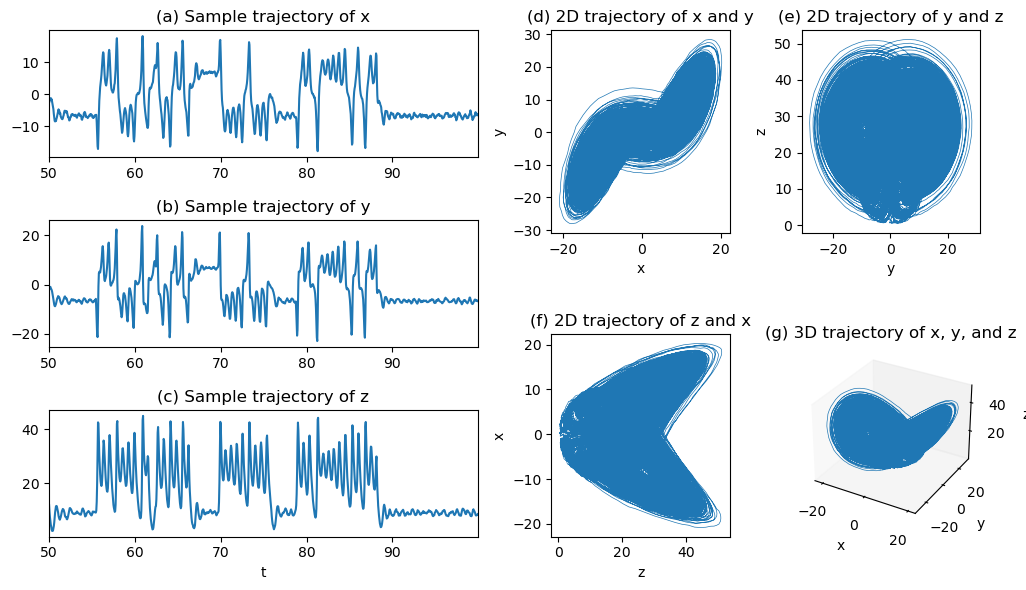

In [33]:
from plot import plot_trajectories

plot_trajectories(x_truth, y_truth, z_truth, dt, sel0=10000, sel1=20000, interv=10)

# 2. Clustering

## 2.1 FCM algorithm with a demonstration case

### Iterative optimization

Clustering Accuracy with Entropy: 96.67%
Clustering Accuracy Baseline (No Entropy): 86.67%


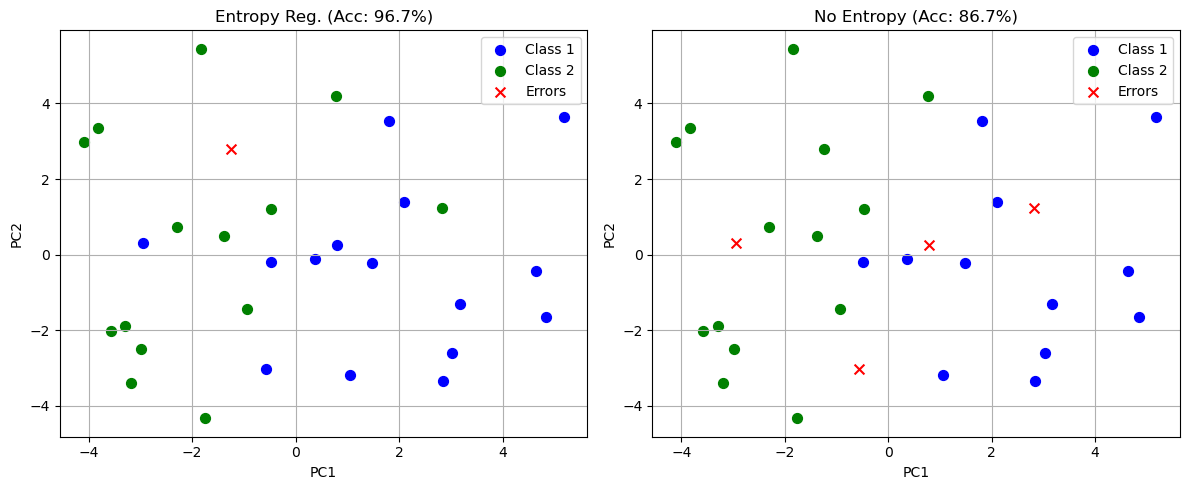

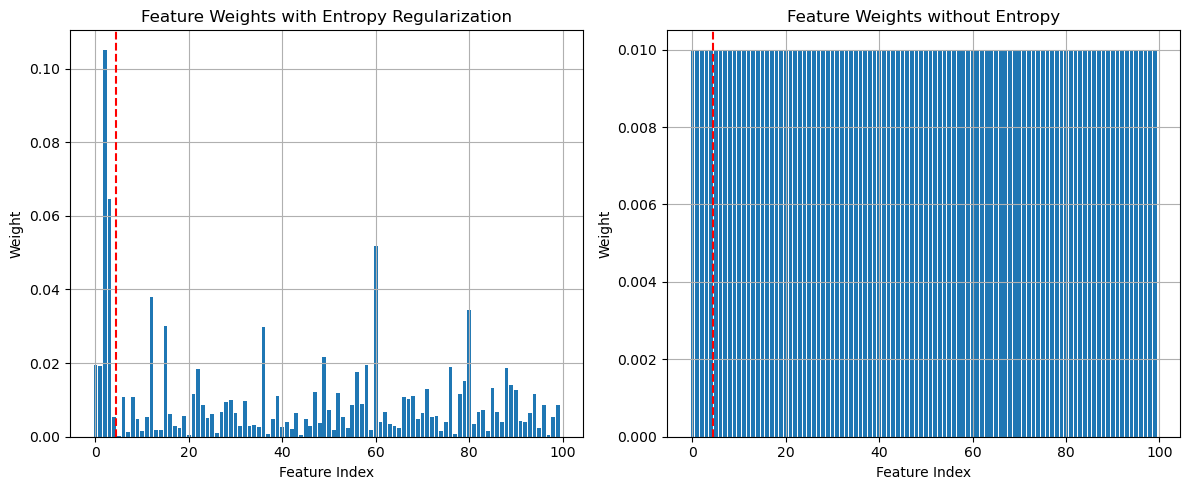

In [4]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from cluster import FCMEntropy
from plot import plot_scatter_weights

np.random.seed(4)

# Parameters
nSamples = 30
nFeatures = 100
signalDim = 5
noiseDim = nFeatures - signalDim

# Generate signal data
mu1 = np.ones(signalDim)
mu2 = -2 * np.ones(signalDim)
sigma_signal = 2 * np.eye(signalDim)
X_signal1 = multivariate_normal.rvs(mean=mu1, cov=sigma_signal, size=nSamples // 2)
X_signal2 = multivariate_normal.rvs(mean=mu2, cov=1.5 * sigma_signal, size=nSamples // 2)
X_signal = np.vstack([X_signal1, X_signal2])

# Generate noise data
sigma_noise = 5
X_noise = sigma_noise * np.random.randn(nSamples, noiseDim)

# Combine data and normalize per sample
dataHD = np.hstack([X_signal, X_noise])
dataHD = (dataHD - dataHD.mean(axis=1, keepdims=True)) / dataHD.std(axis=0, keepdims=True)
trueLabels = np.concatenate([np.ones(nSamples // 2), 2 * np.ones(nSamples // 2)])

# FCM options
options = [1.8, 300, 1e-6, 2.5]  # With entropy
D = nFeatures

# Run FCM with entropy regularization
m, max_iter, tol, lambda_e = options
model = FCMEntropy(num_clusters=2, D=D, m=m, lambda_e=lambda_e, lr=1e-2, num_steps=1000)
results = model.fit(dataHD, optimizer='iterative', tol=tol)
centers_entropy = results['centers']
W_entropy = results['weights']
fuzzypartmat_entropy = results['membership']
loss_entropy = results['loss_history']

# Run baseline FCM without entropy regularization
model = FCMEntropy(num_clusters=2, D=D, m=m, lambda_e=0, lr=1e-2, num_steps=1000)
results = model.fit(dataHD, optimizer='iterative', tol=tol)
centers_baseline = results['centers']
W_baseline = results['weights']
fuzzypartmat_baseline = results['membership']
loss_baseline= results['loss_history']

# Compute clustering accuracy
assigned_entropy = np.argmax(fuzzypartmat_entropy, axis=1) + 1
acc1 = np.mean(assigned_entropy == trueLabels)
acc2 = np.mean(assigned_entropy == (3 - trueLabels))
accuracy_entropy = max(acc1, acc2)

assigned_baseline = np.argmax(fuzzypartmat_baseline, axis=1) + 1
acc1 = np.mean(assigned_baseline == trueLabels)
acc2 = np.mean(assigned_baseline == (3 - trueLabels))
accuracy_baseline = max(acc1, acc2)

print(f"Clustering Accuracy with Entropy: {accuracy_entropy * 100:.2f}%")
print(f"Clustering Accuracy Baseline (No Entropy): {accuracy_baseline * 100:.2f}%")

# Align labels for plotting
assigned_entropy = assigned_entropy if np.sum(assigned_entropy == trueLabels) >= np.sum(assigned_entropy == (3 - trueLabels)) else 3 - assigned_entropy
correct_entropy = assigned_entropy == trueLabels

assigned_baseline = assigned_baseline if np.sum(assigned_baseline == trueLabels) >= np.sum(assigned_baseline == (3 - trueLabels)) else 3 - assigned_baseline
correct_baseline = assigned_baseline == trueLabels

# PCA for visualization
pca = PCA(n_components=2)
score = pca.fit_transform(dataHD)
plot_scatter_weights(score, trueLabels, accuracy_entropy, accuracy_baseline, W_entropy, W_baseline, correct_entropy, correct_baseline, signalDim)
plt.show()

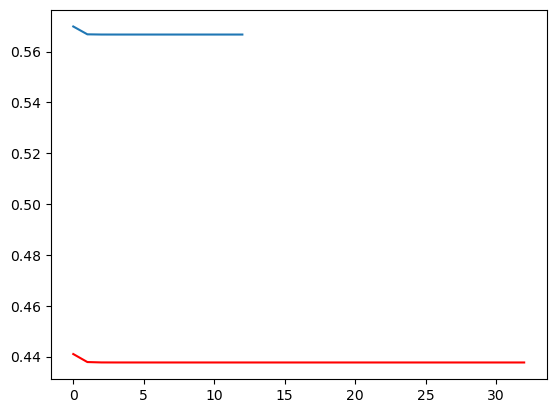

In [2]:
plt.plot(objfcn_entropy,'r')
plt.plot(objfcn_baseline)

In [33]:
m, max_iter, tol, lambda_e = options
model = FCMEntropy(num_clusters=2, D=D, m=m, lambda_e=lambda_e, lr=1e-2, num_steps=1000)
results = model.fit(dataHD, optimizer='iterative', tol=tol)
centers = results['centers']
W_entropy = results['weights']
fuzzypartmat_entropy = results['membership']
loss_list = results['loss_history']
membership = model.predict(dataHD)           # shape (M_test, 3)
hard_labels = model.predict(dataHD, hard=True)  # shape (M_test,)

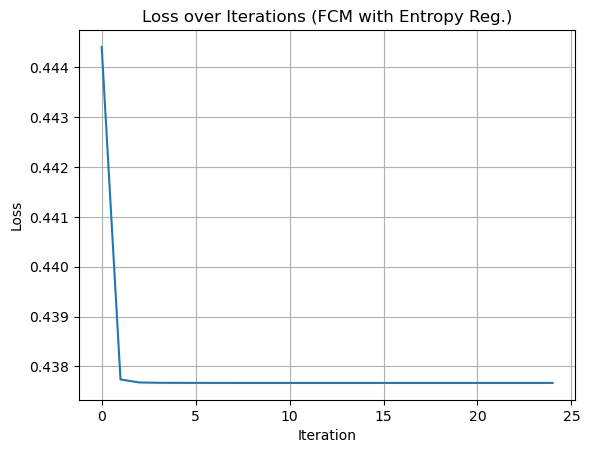

In [18]:
plot_loss(loss_list)

optimization? 

###### multiple simulations

In [111]:
# Parameters
nSimulate = 1000
nSamples = 30
nFeatures = 100
signalDim = 5
noiseDim = nFeatures - signalDim

accuracy_entropy = np.zeros(nSimulate)
accuracy_baseline = np.zeros(nSimulate)
for ns in range(nSimulate):
    # Generate signal data
    mu1 = np.ones(signalDim)
    mu2 = -2 * np.ones(signalDim)
    sigma_signal = 2 * np.eye(signalDim)
    X_signal1 = multivariate_normal.rvs(mean=mu1, cov=sigma_signal, size=nSamples // 2)
    X_signal2 = multivariate_normal.rvs(mean=mu2, cov=1.5 * sigma_signal, size=nSamples // 2)
    X_signal = np.vstack([X_signal1, X_signal2])
    
    # Generate noise data
    sigma_noise = 5
    X_noise = sigma_noise * np.random.randn(nSamples, noiseDim)
    
    # Combine data and normalize per sample
    dataHD = np.hstack([X_signal, X_noise])
    dataHD = (dataHD - dataHD.mean(axis=1, keepdims=True)) / dataHD.std(axis=0, keepdims=True)
    trueLabels = np.concatenate([np.ones(nSamples // 2), 2 * np.ones(nSamples // 2)])
    
    # FCM options
    options = [1.8, 300, 1e-6, 2.5]  # With entropy
    D = nFeatures
    
    # Run FCM with entropy regularization
    centers_entropy, fuzzypartmat_entropy, W_entropy, objfcn_entropy = fcm_entropy(dataHD, 2, options, D)
    
    # Run baseline FCM without entropy regularization
    options_baseline = options.copy()
    options_baseline[3] = 0
    centers_baseline, fuzzypartmat_baseline, W_baseline, objfcn_baseline = fcm_entropy(dataHD, 2, options_baseline, D)
    
    # Compute clustering accuracy
    assigned_entropy = np.argmax(fuzzypartmat_entropy, axis=1) + 1
    acc1 = np.mean(assigned_entropy == trueLabels)
    acc2 = np.mean(assigned_entropy == (3 - trueLabels))
    accuracy_entropy[ns] = max(acc1, acc2)
    
    assigned_baseline = np.argmax(fuzzypartmat_baseline, axis=1) + 1
    acc1 = np.mean(assigned_baseline == trueLabels)
    acc2 = np.mean(assigned_baseline == (3 - trueLabels))
    accuracy_baseline[ns] = max(acc1, acc2)

accuracy_entropy = np.mean(accuracy_entropy)
accuracy_baseline = np.mean(accuracy_baseline)
print(f"Clustering Accuracy with Entropy: {accuracy_entropy * 100:.2f}%")
print(f"Clustering Accuracy Baseline (No Entropy): {accuracy_baseline * 100:.2f}%")


Clustering Accuracy with Entropy: 70.84%
Clustering Accuracy Baseline (No Entropy): 70.79%


###### more data samples

In [151]:
# Parameters
nSimulate = 1000
nSamples = 10000
nFeatures = 100
signalDim = 5
noiseDim = nFeatures - signalDim

accuracy_entropy = np.zeros(nSimulate)
accuracy_baseline = np.zeros(nSimulate)
for ns in range(nSimulate):
    # Generate signal data
    mu1 = np.ones(signalDim)
    mu2 = -2 * np.ones(signalDim)
    sigma_signal = 2 * np.eye(signalDim)
    X_signal1 = multivariate_normal.rvs(mean=mu1, cov=sigma_signal, size=nSamples // 2)
    X_signal2 = multivariate_normal.rvs(mean=mu2, cov=1.5 * sigma_signal, size=nSamples // 2)
    X_signal = np.vstack([X_signal1, X_signal2])
    
    # Generate noise data
    sigma_noise = 5
    X_noise = sigma_noise * np.random.randn(nSamples, noiseDim)
    
    # Combine data and normalize per sample
    dataHD = np.hstack([X_signal, X_noise])
    dataHD = (dataHD - dataHD.mean(axis=1, keepdims=True)) / dataHD.std(axis=0, keepdims=True)
    trueLabels = np.concatenate([np.ones(nSamples // 2), 2 * np.ones(nSamples // 2)])
    
    # FCM options
    options = [1.8, 300, 1e-6, 2.5]  # With entropy
    D = nFeatures
    
    # Run FCM with entropy regularization
    centers_entropy, fuzzypartmat_entropy, W_entropy, objfcn_entropy = fcm_entropy(dataHD, 2, options, D)
    
    # Run baseline FCM without entropy regularization
    options_baseline = options.copy()
    options_baseline[3] = 0
    centers_baseline, fuzzypartmat_baseline, W_baseline, objfcn_baseline = fcm_entropy(dataHD, 2, options_baseline, D)
    
    # Compute clustering accuracy
    assigned_entropy = np.argmax(fuzzypartmat_entropy, axis=0) + 1
    acc1 = np.mean(assigned_entropy == trueLabels)
    acc2 = np.mean(assigned_entropy == (3 - trueLabels))
    accuracy_entropy[ns] = max(acc1, acc2)
    
    assigned_baseline = np.argmax(fuzzypartmat_baseline, axis=0) + 1
    acc1 = np.mean(assigned_baseline == trueLabels)
    acc2 = np.mean(assigned_baseline == (3 - trueLabels))
    accuracy_baseline[ns] = max(acc1, acc2)

accuracy_entropy = np.mean(accuracy_entropy)
accuracy_baseline = np.mean(accuracy_baseline)
print(f"Clustering Accuracy with Entropy: {accuracy_entropy * 100:.2f}%")
print(f"Clustering Accuracy Baseline (No Entropy): {accuracy_baseline * 100:.2f}%")


Clustering Accuracy with Entropy: 93.81%
Clustering Accuracy Baseline (No Entropy): 94.48%


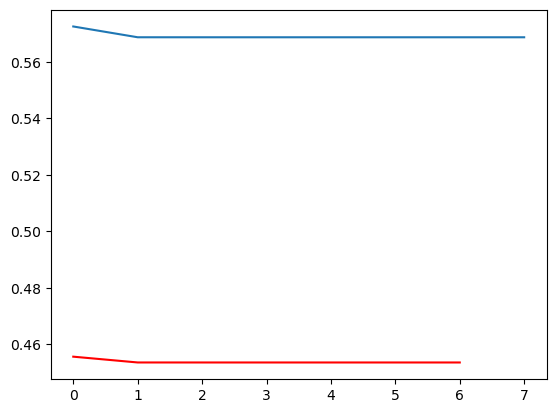

In [152]:
plt.plot(objfcn_entropy,'r')
plt.plot(objfcn_baseline)

### JAX-gradient descent

In [ ]:
from cluster import FCMEntropy

In [9]:
m, max_iter, tol, lambda_e = options
model = FCMEntropy(num_clusters=2, D=D, m=m, lambda_e=lambda_e, lr=1e-2, num_steps=1000)
results = model.fit(dataHD, optimizer='gradient_descent')
centers = results['centers']
W_entropy = results['weights']
fuzzypartmat_entropy = results['membership']
loss_list = results['loss_history']
grad_norm_log = results['grad_norm_log']
membership = model.predict(dataHD)           # shape (M_test, 3)
hard_labels = model.predict(dataHD, hard=True)  # shape (M_test,)

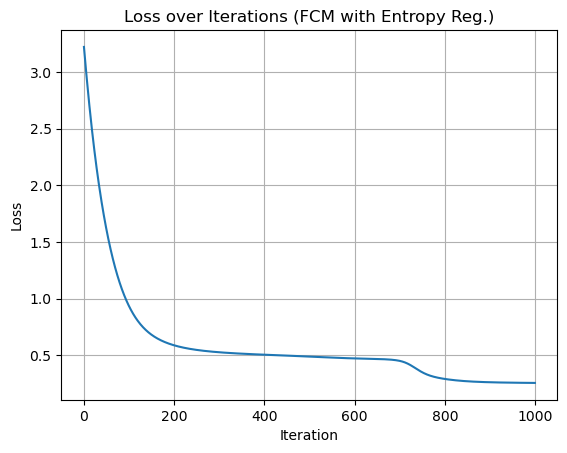

In [14]:
from plot import plot_loss
plot_loss(loss_list)

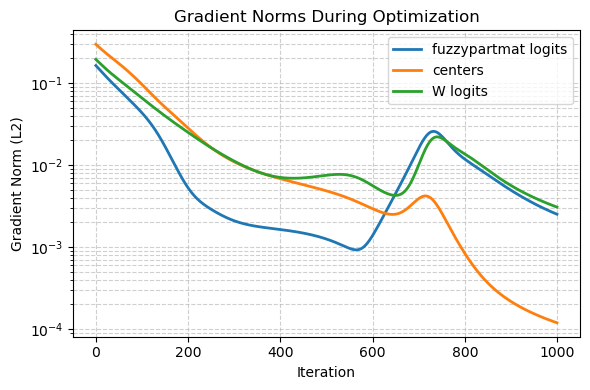

In [15]:
from plot import plot_grad_norms
plot_grad_norms(grad_norm_log)

Clustering Accuracy with Entropy: 93.33%
Clustering Accuracy Baseline (No Entropy): 86.67%


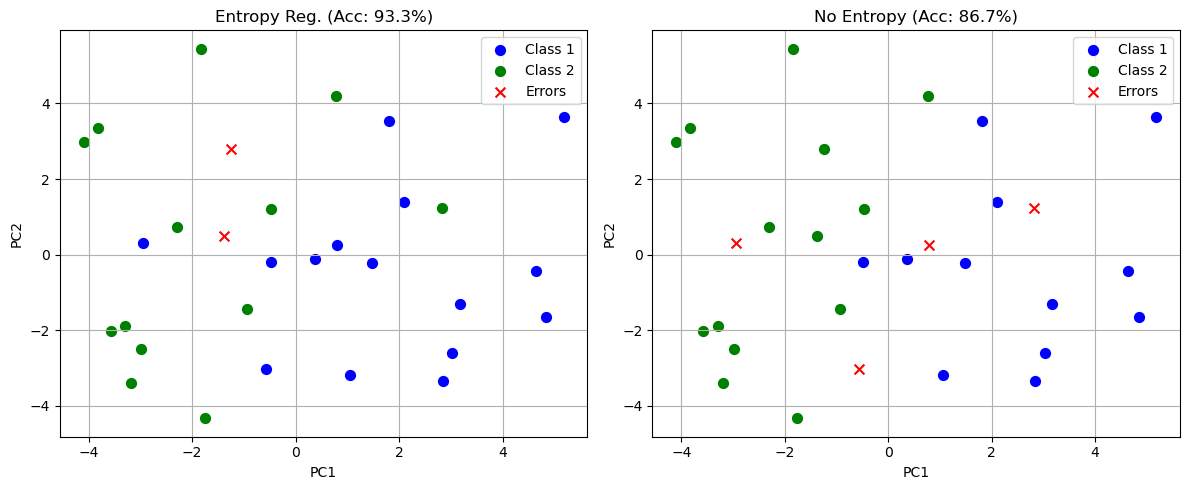

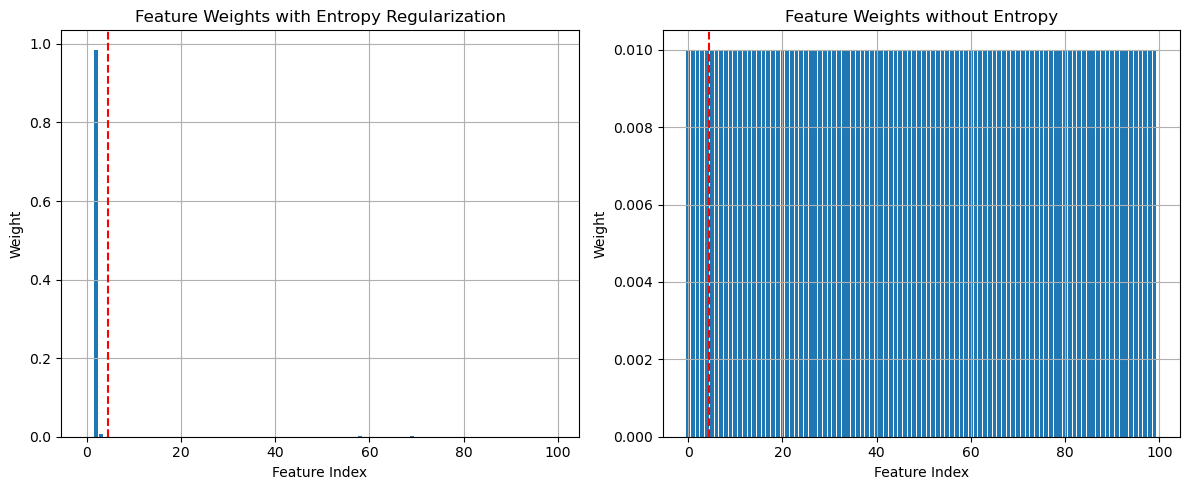

In [16]:
# Compute clustering accuracy
assigned_entropy = np.argmax(fuzzypartmat_entropy, axis=1) + 1
acc1 = np.mean(assigned_entropy == trueLabels)
acc2 = np.mean(assigned_entropy == (3 - trueLabels))
accuracy_entropy = max(acc1, acc2)

assigned_baseline = np.argmax(fuzzypartmat_baseline, axis=1) + 1
acc1 = np.mean(assigned_baseline == trueLabels)
acc2 = np.mean(assigned_baseline == (3 - trueLabels))
accuracy_baseline = max(acc1, acc2)

print(f"Clustering Accuracy with Entropy: {accuracy_entropy * 100:.2f}%")
print(f"Clustering Accuracy Baseline (No Entropy): {accuracy_baseline * 100:.2f}%")

# Align labels for plotting
assigned_entropy = assigned_entropy if np.sum(assigned_entropy == trueLabels) >= np.sum(assigned_entropy == (3 - trueLabels)) else 3 - assigned_entropy
correct_entropy = assigned_entropy == trueLabels

assigned_baseline = assigned_baseline if np.sum(assigned_baseline == trueLabels) >= np.sum(assigned_baseline == (3 - trueLabels)) else 3 - assigned_baseline
correct_baseline = assigned_baseline == trueLabels

# PCA for visualization
pca = PCA(n_components=2)
score = pca.fit_transform(dataHD)
plot_scatter_weights(score, trueLabels, accuracy_entropy, accuracy_baseline, W_entropy, W_baseline, correct_entropy, correct_baseline, signalDim)
plt.show()

It is the optimization (once the optimizer finds a 'right' feature weights, the accuracy significantly improves)

###### Change the random seed

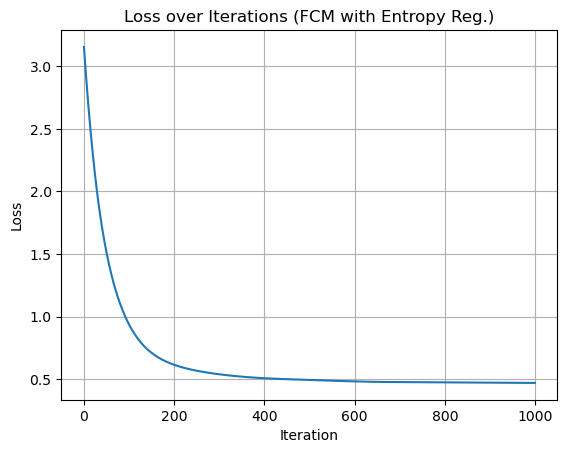

In [10]:
m, max_iter, tol, lambda_e = options

# params = init_from_warm_start(dataHD, 2, options, D)
# data_jax = jnp.array(dataHD)
data_jax = dataHD
centers, W_entropy, fuzzypartmat_entropy, loss_list, grad_norm_log = train(
    data_jax,
    num_clusters=2,
    D=D,
    m=m,
    lambda_e=lambda_e,
    lr=1e-2,
    num_steps=1000,
    # params=params,
    seed=2
)

plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations (FCM with Entropy Reg.)')
plt.grid(True)
plt.show()


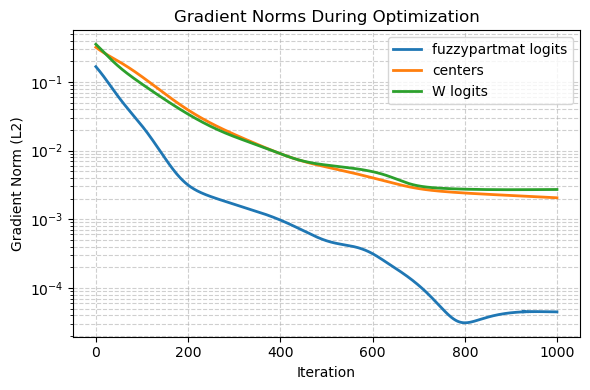

In [11]:
from plot import plot_grad_norms

plot_grad_norms(grad_norm_log)

Clustering Accuracy with Entropy: 50.00%
Clustering Accuracy Baseline (No Entropy): 86.67%


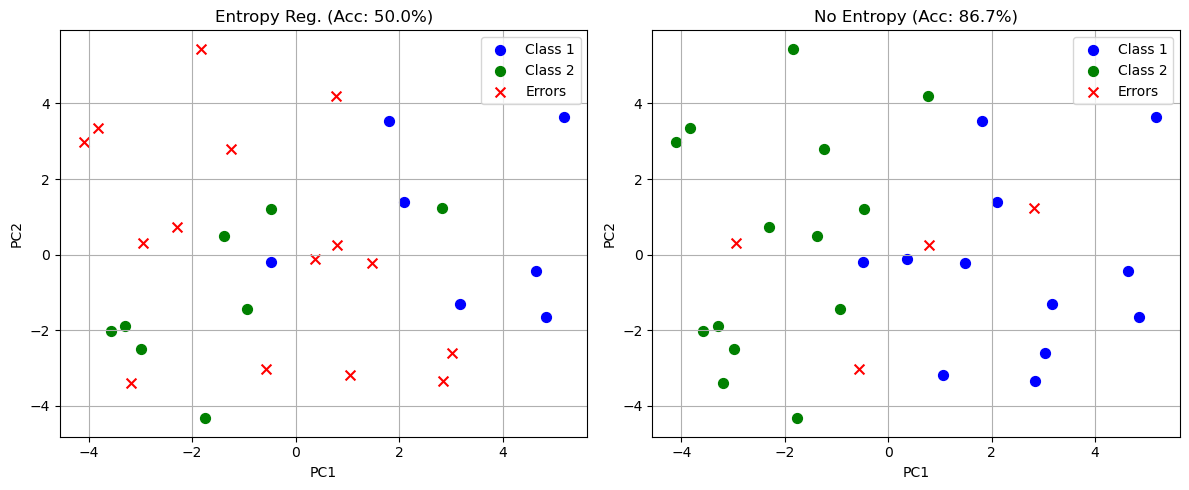

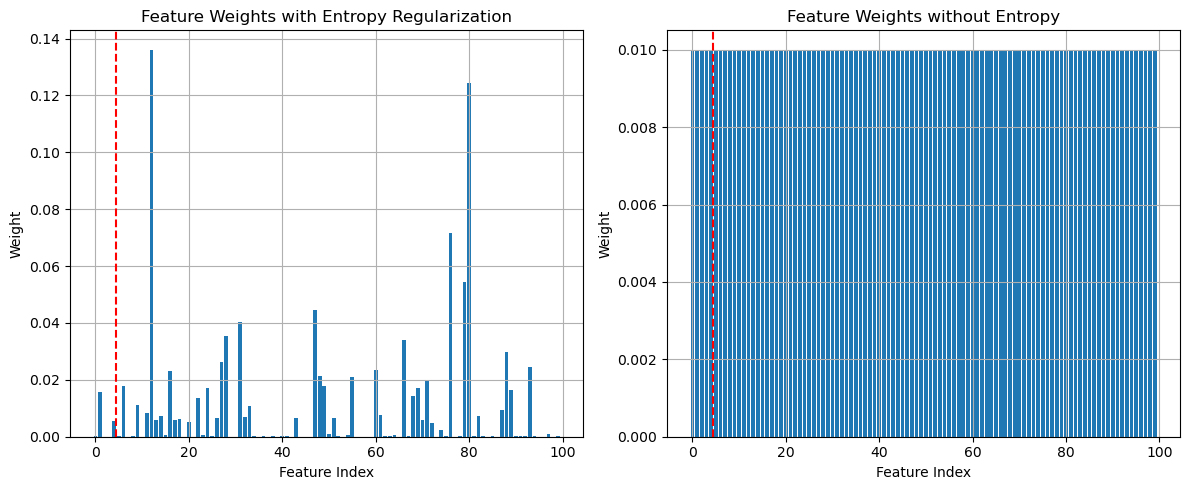

In [12]:
# Compute clustering accuracy
assigned_entropy = np.argmax(fuzzypartmat_entropy, axis=1) + 1
acc1 = np.mean(assigned_entropy == trueLabels)
acc2 = np.mean(assigned_entropy == (3 - trueLabels))
accuracy_entropy = max(acc1, acc2)

assigned_baseline = np.argmax(fuzzypartmat_baseline, axis=1) + 1
acc1 = np.mean(assigned_baseline == trueLabels)
acc2 = np.mean(assigned_baseline == (3 - trueLabels))
accuracy_baseline = max(acc1, acc2)

print(f"Clustering Accuracy with Entropy: {accuracy_entropy * 100:.2f}%")
print(f"Clustering Accuracy Baseline (No Entropy): {accuracy_baseline * 100:.2f}%")

# Align labels for plotting
assigned_entropy = assigned_entropy if np.sum(assigned_entropy == trueLabels) >= np.sum(assigned_entropy == (3 - trueLabels)) else 3 - assigned_entropy
correct_entropy = assigned_entropy == trueLabels

assigned_baseline = assigned_baseline if np.sum(assigned_baseline == trueLabels) >= np.sum(assigned_baseline == (3 - trueLabels)) else 3 - assigned_baseline
correct_baseline = assigned_baseline == trueLabels

# PCA for visualization
pca = PCA(n_components=2)
score = pca.fit_transform(dataHD)
plot_scatter_weights(score, trueLabels, accuracy_entropy, accuracy_baseline, W_entropy, W_baseline, correct_entropy, correct_baseline, signalDim)
plt.show()

###### more data samples

Clustering Accuracy with Entropy: 95.90%
Clustering Accuracy Baseline (No Entropy): 95.90%


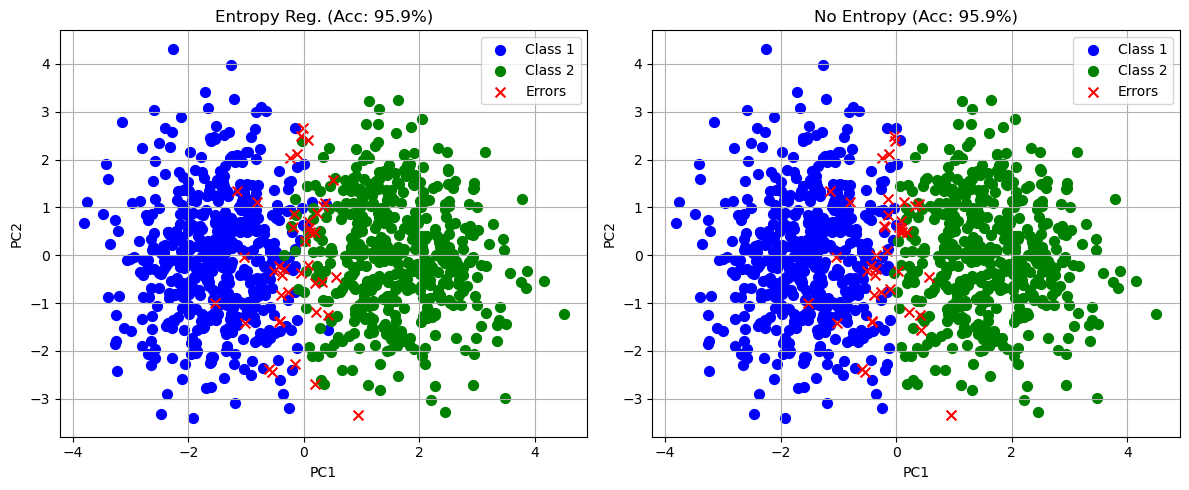

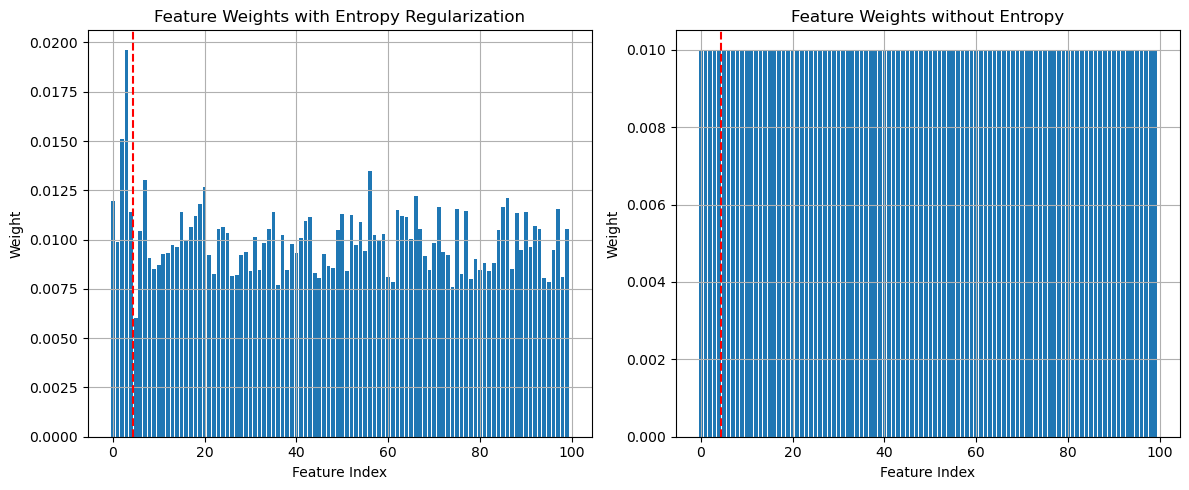

In [24]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from cluster import fcm_entropy
from plot import plot_scatter_weights

np.random.seed(4)

# Parameters
nSamples = 1000
nFeatures = 100
signalDim = 5
noiseDim = nFeatures - signalDim

# Generate signal data
mu1 = np.ones(signalDim)
mu2 = -2 * np.ones(signalDim)
sigma_signal = 2 * np.eye(signalDim)
X_signal1 = multivariate_normal.rvs(mean=mu1, cov=sigma_signal, size=nSamples // 2)
X_signal2 = multivariate_normal.rvs(mean=mu2, cov=1.5 * sigma_signal, size=nSamples // 2)
X_signal = np.vstack([X_signal1, X_signal2])

# Generate noise data
sigma_noise = 5
X_noise = sigma_noise * np.random.randn(nSamples, noiseDim)

# Combine data and normalize per sample
dataHD = np.hstack([X_signal, X_noise])
dataHD = (dataHD - dataHD.mean(axis=1, keepdims=True)) / dataHD.std(axis=0, keepdims=True)
trueLabels = np.concatenate([np.ones(nSamples // 2), 2 * np.ones(nSamples // 2)])

# FCM options
options = [1.8, 300, 1e-6, 2.5]  # With entropy
D = nFeatures

# Run FCM with entropy regularization
centers_entropy, fuzzypartmat_entropy, W_entropy, objfcn_entropy = fcm_entropy(dataHD, 2, options, D)

# Run baseline FCM without entropy regularization
options_baseline = options.copy()
options_baseline[3] = 0
centers_baseline, fuzzypartmat_baseline, W_baseline, objfcn_baseline = fcm_entropy(dataHD, 2, options_baseline, D)

# Compute clustering accuracy
assigned_entropy = np.argmax(fuzzypartmat_entropy, axis=1) + 1
acc1 = np.mean(assigned_entropy == trueLabels)
acc2 = np.mean(assigned_entropy == (3 - trueLabels))
accuracy_entropy = max(acc1, acc2)

assigned_baseline = np.argmax(fuzzypartmat_baseline, axis=1) + 1
acc1 = np.mean(assigned_baseline == trueLabels)
acc2 = np.mean(assigned_baseline == (3 - trueLabels))
accuracy_baseline = max(acc1, acc2)

print(f"Clustering Accuracy with Entropy: {accuracy_entropy * 100:.2f}%")
print(f"Clustering Accuracy Baseline (No Entropy): {accuracy_baseline * 100:.2f}%")

# Align labels for plotting
assigned_entropy = assigned_entropy if np.sum(assigned_entropy == trueLabels) >= np.sum(assigned_entropy == (3 - trueLabels)) else 3 - assigned_entropy
correct_entropy = assigned_entropy == trueLabels

assigned_baseline = assigned_baseline if np.sum(assigned_baseline == trueLabels) >= np.sum(assigned_baseline == (3 - trueLabels)) else 3 - assigned_baseline
correct_baseline = assigned_baseline == trueLabels

# PCA for visualization
pca = PCA(n_components=2)
score = pca.fit_transform(dataHD)
plot_scatter_weights(score, trueLabels, accuracy_entropy, accuracy_baseline, W_entropy, W_baseline, correct_entropy, correct_baseline, signalDim)
plt.show()

Iter 0, Loss: 4.963095188140869
Iter 100, Loss: 1.4965975284576416
Iter 200, Loss: 0.7936870455741882
Iter 300, Loss: 0.6170583963394165
Iter 400, Loss: 0.5540940165519714
Iter 500, Loss: 0.5264332890510559
Iter 600, Loss: 0.5126858353614807
Iter 700, Loss: 0.5053836703300476
Iter 800, Loss: 0.49997398257255554
Iter 900, Loss: 0.4955946207046509


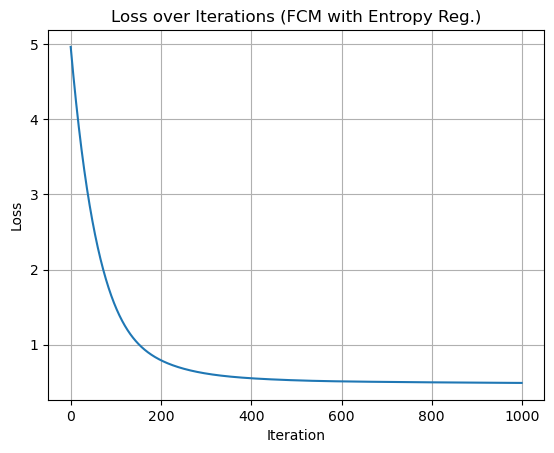

In [28]:
m, max_iter, tol, lambda_e = options

# params = init_from_warm_start(dataHD, 2, options, D)
# data_jax = jnp.array(dataHD)
data_jax = dataHD
centers, W_entropy, fuzzypartmat_entropy, loss_list, grad_norm_log = train(
    data_jax,
    num_clusters=2,
    D=D,
    m=m,
    lambda_e=lambda_e,
    lr=1e-2,
    num_steps=1000,
    # params=params
)

plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations (FCM with Entropy Reg.)')
plt.grid(True)
plt.show()


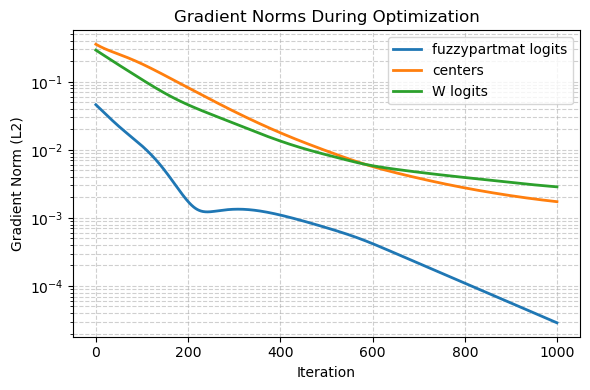

In [30]:
def plot_grad_norms(grad_norm_log):
    # Convert from list of PyTrees to arrays
    fuzzypart_norms = np.array([float(g[0]) for g in grad_norm_log])
    center_norms = np.array([float(g[1]) for g in grad_norm_log])
    W_norms = np.array([float(g[2]) for g in grad_norm_log])

    steps = np.arange(len(grad_norm_log))

    plt.figure(figsize=(6, 4))
    plt.plot(steps, fuzzypart_norms, label='fuzzypartmat logits', linewidth=2)
    plt.plot(steps, center_norms, label='centers', linewidth=2)
    plt.plot(steps, W_norms, label='W logits', linewidth=2)

    plt.yscale('log')  # log scale helps visualize small or diverging norms
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm (L2)')
    plt.title('Gradient Norms During Optimization')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_grad_norms(grad_norm_log)


Clustering Accuracy with Entropy: 56.90%
Clustering Accuracy Baseline (No Entropy): 95.90%


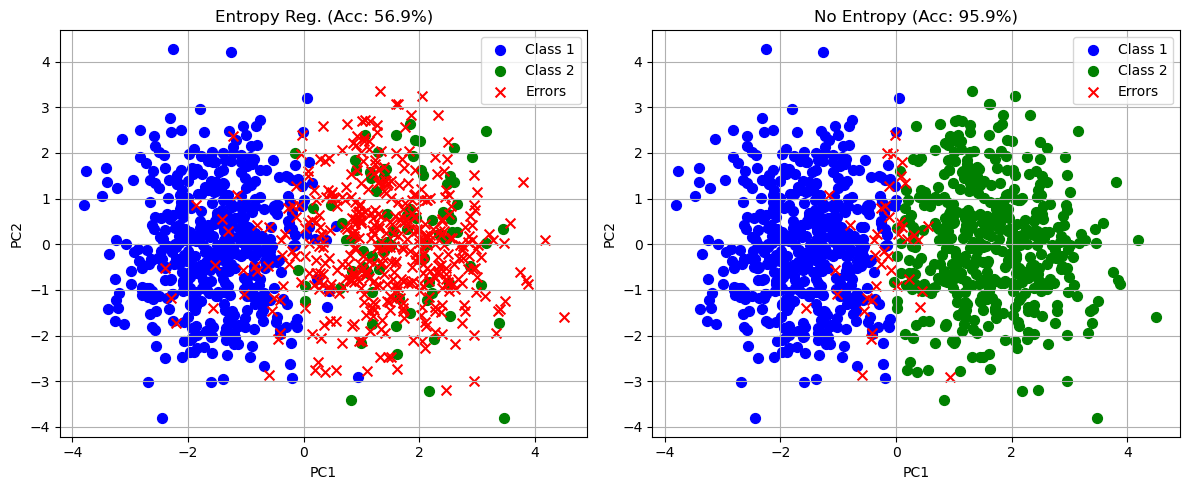

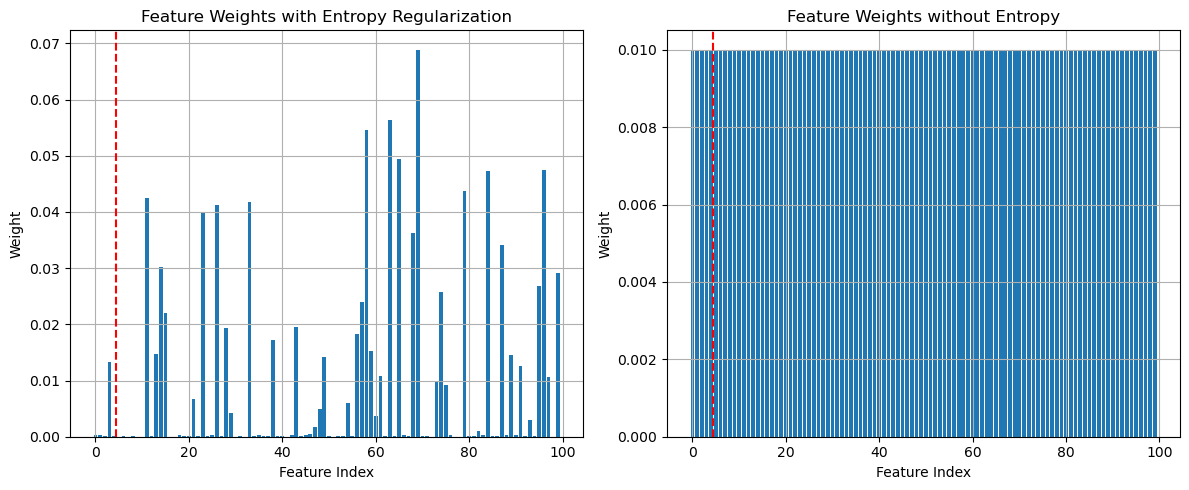

In [31]:
# Compute clustering accuracy
assigned_entropy = np.argmax(fuzzypartmat_entropy, axis=1) + 1
acc1 = np.mean(assigned_entropy == trueLabels)
acc2 = np.mean(assigned_entropy == (3 - trueLabels))
accuracy_entropy = max(acc1, acc2)

assigned_baseline = np.argmax(fuzzypartmat_baseline, axis=1) + 1
acc1 = np.mean(assigned_baseline == trueLabels)
acc2 = np.mean(assigned_baseline == (3 - trueLabels))
accuracy_baseline = max(acc1, acc2)

print(f"Clustering Accuracy with Entropy: {accuracy_entropy * 100:.2f}%")
print(f"Clustering Accuracy Baseline (No Entropy): {accuracy_baseline * 100:.2f}%")

# Align labels for plotting
assigned_entropy = assigned_entropy if np.sum(assigned_entropy == trueLabels) >= np.sum(assigned_entropy == (3 - trueLabels)) else 3 - assigned_entropy
correct_entropy = assigned_entropy == trueLabels

assigned_baseline = assigned_baseline if np.sum(assigned_baseline == trueLabels) >= np.sum(assigned_baseline == (3 - trueLabels)) else 3 - assigned_baseline
correct_baseline = assigned_baseline == trueLabels

# PCA for visualization
pca = PCA(n_components=2)
score = pca.fit_transform(dataHD)
plot_scatter_weights(score, trueLabels, accuracy_entropy, accuracy_baseline, W_entropy, W_baseline, correct_entropy, correct_baseline, signalDim)
plt.show()

###### multiple simulations

In [33]:
# Parameters
nSimulate = 1000
nSamples = 30
nFeatures = 100
signalDim = 5
noiseDim = nFeatures - signalDim

accuracy_entropy = np.zeros(nSimulate)
accuracy_baseline = np.zeros(nSimulate)
for ns in range(nSimulate):
    # Generate signal data
    mu1 = np.ones(signalDim)
    mu2 = -2 * np.ones(signalDim)
    sigma_signal = 2 * np.eye(signalDim)
    X_signal1 = multivariate_normal.rvs(mean=mu1, cov=sigma_signal, size=nSamples // 2)
    X_signal2 = multivariate_normal.rvs(mean=mu2, cov=1.5 * sigma_signal, size=nSamples // 2)
    X_signal = np.vstack([X_signal1, X_signal2])
    
    # Generate noise data
    sigma_noise = 5
    X_noise = sigma_noise * np.random.randn(nSamples, noiseDim)
    
    # Combine data and normalize per sample
    dataHD = np.hstack([X_signal, X_noise])
    dataHD = (dataHD - dataHD.mean(axis=1, keepdims=True)) / dataHD.std(axis=0, keepdims=True)
    trueLabels = np.concatenate([np.ones(nSamples // 2), 2 * np.ones(nSamples // 2)])
    
    # FCM options
    options = [1.8, 300, 1e-6, 2.5]  # With entropy
    D = nFeatures
    
    # Run FCM with entropy regularization
    centers, W_entropy, fuzzypartmat_entropy, loss_list, grad_norm_log = train(dataHD, 2, D, m, lambda_e, lr=1e-2, num_steps=500)
    # Run baseline FCM without entropy regularization
    options_baseline = options.copy()
    options_baseline[3] = 0
    centers_baseline, fuzzypartmat_baseline, W_baseline, objfcn_baseline = fcm_entropy(dataHD, 2, options_baseline, D)
    
    # Compute clustering accuracy
    assigned_entropy = np.argmax(fuzzypartmat_entropy, axis=1) + 1
    acc1 = np.mean(assigned_entropy == trueLabels)
    acc2 = np.mean(assigned_entropy == (3 - trueLabels))
    accuracy_entropy[ns] = max(acc1, acc2)
    
    assigned_baseline = np.argmax(fuzzypartmat_baseline, axis=1) + 1
    acc1 = np.mean(assigned_baseline == trueLabels)
    acc2 = np.mean(assigned_baseline == (3 - trueLabels))
    accuracy_baseline[ns] = max(acc1, acc2)

accuracy_entropy = np.mean(accuracy_entropy)
accuracy_baseline = np.mean(accuracy_baseline)
print(f"Clustering Accuracy with Entropy: {accuracy_entropy * 100:.2f}%")
print(f"Clustering Accuracy Baseline (No Entropy): {accuracy_baseline * 100:.2f}%")


Clustering Accuracy with Entropy: 59.72%
Clustering Accuracy Baseline (No Entropy): 70.76%


## 2.2 Clustering L63 with FCM

In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from cluster import FCMEntropy

data = np.load('../data/data_L63.npz')
N_gap = data['N_gap'].item()
dt_obs = data['dt_obs'].item()
S_obs = data['S_obs']
truth_full = np.concatenate((data['x_truth'][:,None], data['y_truth'][:,None], data['z_truth'][:,None]), axis=1)
truth_full = truth_full[::N_gap]

# split training and test data set 
train_size = 1600
test_size = 400
data_size = train_size
data = truth_full[:train_size]
S_obs = S_obs[:train_size]
# data = truth_full[train_size:train_size+data_size]

Nt, D = data.shape
L = 2 # delay steps
data_embedded = np.concatenate([data[i:Nt - L + i + 1] for i in range(L)], axis=1) # (x0,y0,z0,x1,y1,z1,...)

# standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_embedded)

# clustering
K = 2 # number of clusters
model = FCMEntropy(num_clusters=K, D=D, m=2.0, lambda_e=0.01, num_steps=500)
results = model.fit(data_scaled, optimizer='iterative', tol=1e-6)
membership = results['membership']
centers = results['centers']
labels = np.argmax(membership, axis=1)
# labels = -labels + 1

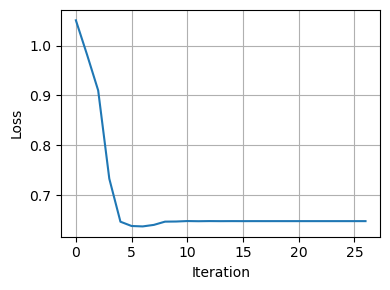

In [6]:
from plot import plot_loss
loss_history = results['loss_history']
plot_loss(loss_history)

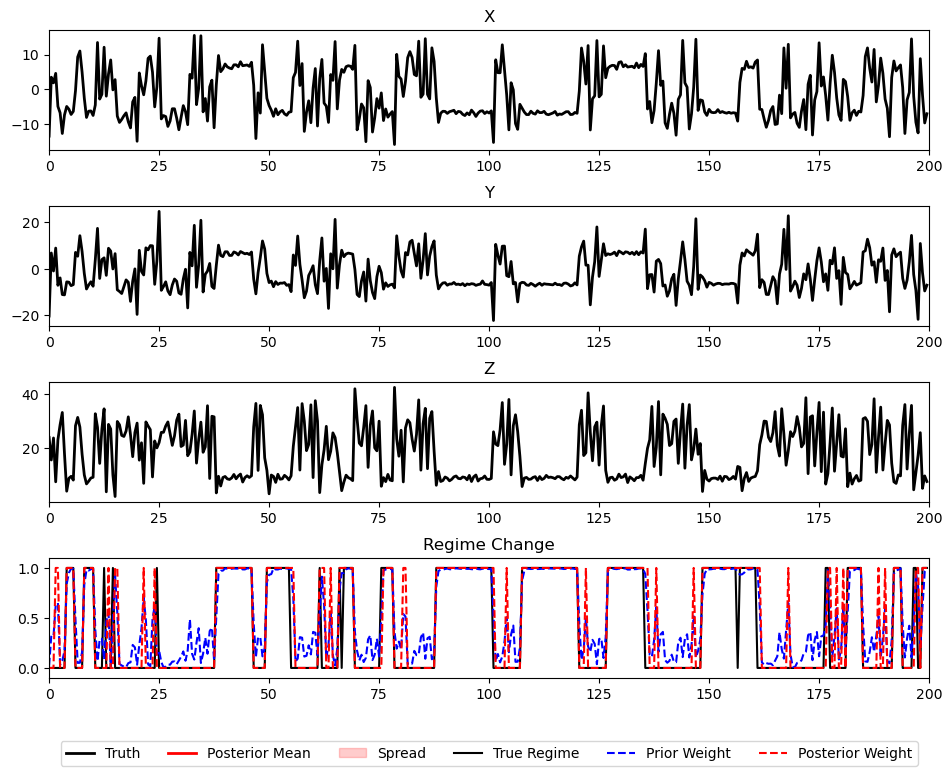

In [12]:
from plot import plot_l63_series
plot_l63_series(dt_obs, 0, 400, 1, data[1:,0], data[1:,1], data[1:,2], S_obs[1:], np.full((Nt-1,3), np.nan), np.zeros((Nt-1,3)), membership[:,1], labels, xlim=(0,200))

In [2]:
import numpy as np


In [26]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from cluster import FCMEntropy

data = np.load('../data/data_L63.npz')
N_gap = data['N_gap'].item()
dt_obs = data['dt_obs'].item()
S_obs = data['S_obs']
truth_full = np.concatenate((data['x_truth'][:,None], data['y_truth'][:,None], data['z_truth'][:,None]), axis=1)
truth_full = truth_full[::N_gap]

# split training and test data set 
train_size = 1600
test_size = 400
data_size = train_size
data = truth_full[:train_size]
S_obs = S_obs[:train_size]
# data = truth_full[train_size:train_size+data_size]

Nt, D = data.shape
L = 3 # delay steps
# data_embedded = np.concatenate([data[i:Nt - L + i + 1] for i in range(L)], axis=1) # (x0,y0,z0,x1,y1,z1,...)
features = []
features.append(data[L-1:Nt, 2][:,None])
features.append(np.mean(np.stack([np.abs(data[i:Nt-L+i+1]-data[i-1:Nt-L+i]) for i in range(1,L)], axis=2), axis=2))
data_embedded = np.concatenate(features, axis=1)

# standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_embedded)

# clustering
K = 2 # number of clusters
model = FCMEntropy(num_clusters=K, D=D, m=2, lambda_e=2, num_steps=500)
results = model.fit(data_scaled, optimizer='iterative', tol=1e-6)
# results = model.fit(data_scaled, optimizer='gradient_descent')
membership = results['membership']
centers = results['centers']
labels = np.argmax(membership, axis=1)
# labels = -labels + 1

ValueError: operands could not be broadcast together with shapes (3,) (1598,4) 

In [27]:
data[L-1:Nt, 2].shape

(1598,)

In [29]:
features[1].shape

(1598, 3)

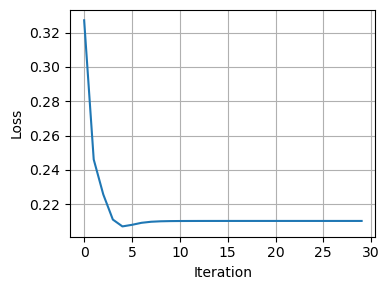

In [25]:
from plot import plot_loss
loss_history = results['loss_history']
plot_loss(loss_history)

In [22]:
labels = -labels + 1

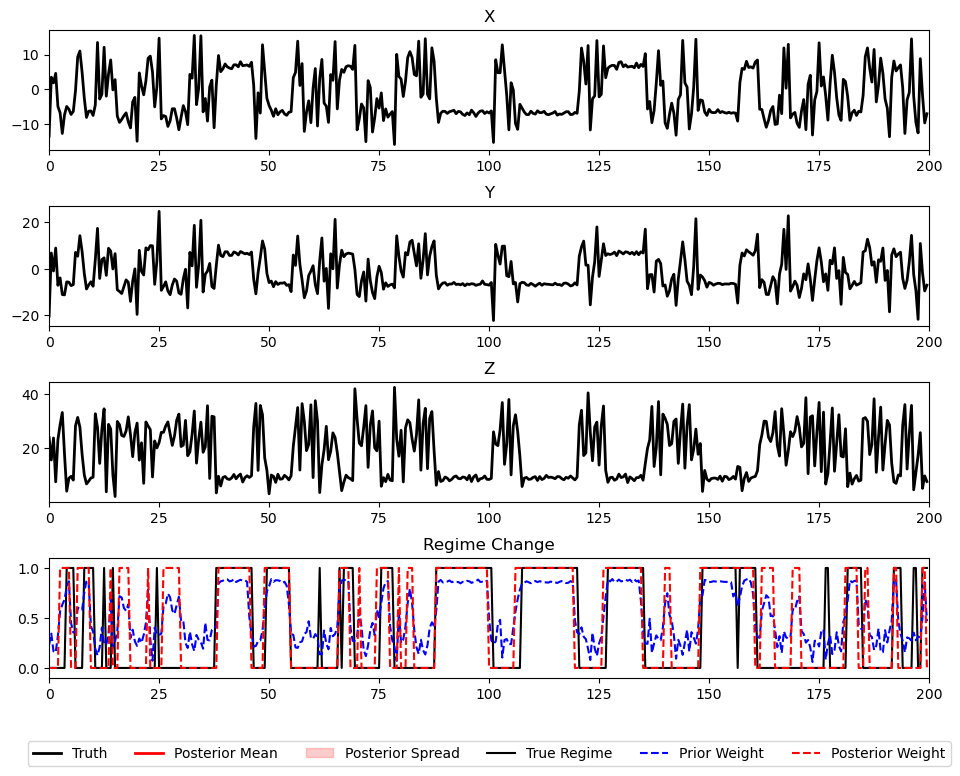

In [23]:
from plot import plot_l63_series
plot_l63_series(dt_obs, 0, 400, 1, data[1:,0], data[1:,1], data[1:,2], S_obs[1:], np.full((Nt-1,3), np.nan), np.zeros((Nt-1,3)), membership[:,0], labels, xlim=(0,200))

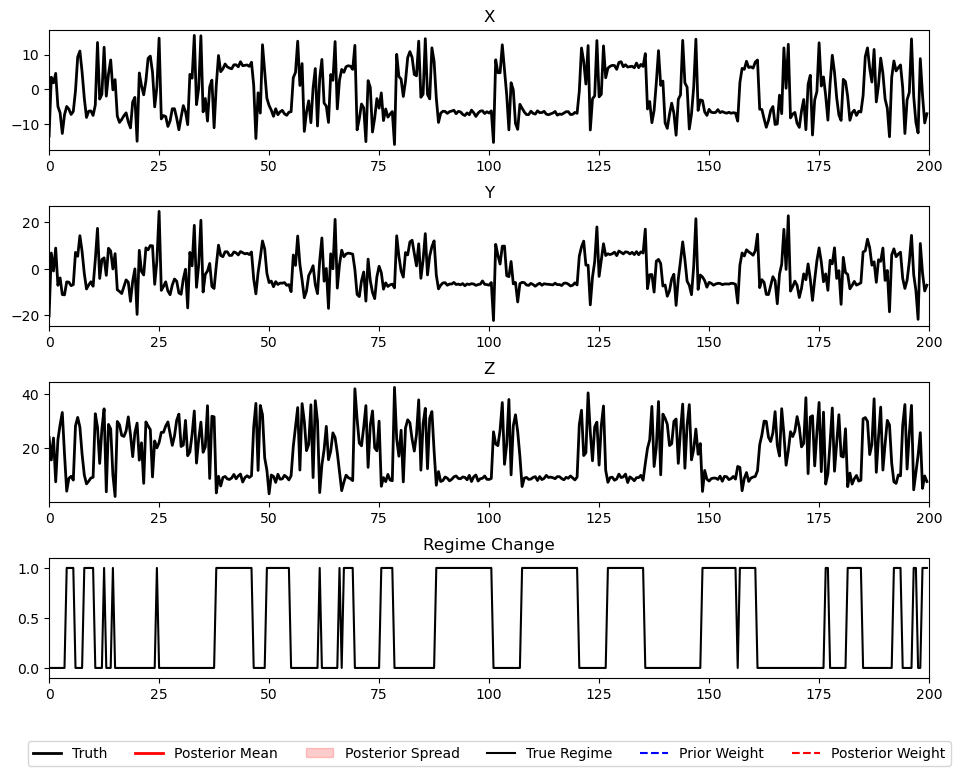

In [53]:
from plot import plot_l63_series
plot_l63_series(dt_obs, 0, 400, 1, data[1:,0], data[1:,1], data[1:,2], S_obs[1:], np.full((Nt-1,3), np.nan), np.zeros((Nt-1,3)), np.full(Nt-1, np.nan), np.full(Nt-1, np.nan), xlim=(0,200))

# 3. Multi-model EnKF

#### singlue regime for checking code

In [17]:
import numpy as np
from enkf import eakf, construct_GC
from L63_noisy import L63RegimeModel
from time import time

np.random.seed(0)

# --------------------- load data --------------------------
train_size = 1600
test_size = 400
data = np.load('../data/data_L63_singleregime.npz')
dt = data['dt'].item()
N_gap = data['N_gap'].item()
sigma_obs = data['sigma_obs'].item()
dt_obs = data['dt_obs'].item()
truth_full = np.concatenate((data['x_truth'][:,None], data['y_truth'][:,None], data['z_truth'][:,None]), axis=1)
truth_full = truth_full[::N_gap]
obs_full = np.concatenate((data['x_obs'][:,None], data['y_obs'][:,None], data['z_obs'][:,None]), axis=1)

# split training and test data set (training means tuning inflation and localzaiton)
data_size = train_size
# truth = truth_full[:train_size]
# obs = obs_full[:train_size]
truth = truth_full[train_size:train_size+data_size]
obs = obs_full[train_size:train_size+data_size]

# ---------------------- model parameters ---------------------
sigma_x = np.sqrt(2.0)
sigma_y = 1.0
sigma_z = 1.0
sigma_obs = 2 * np.sqrt(2)
# Regime switching (Continuous-time Markov process)
regimes = [
    {'sigma': 10, 'beta': 8/3, 'rho': 28},
    {'sigma': 20, 'beta': 5,   'rho': 10},
    {'sigma': 15, 'beta': 4,   'rho': 35}
]
n_regimes = len(regimes)
routing_matrix = np.array([
    [1, 0, 0],
    [1, 0, 0],
    [0.8, 0.2, 0]
])
holding_parameters = np.array([0.2, 0.3, 0.4])
# dt = 5e-3 # Time step size
Nx = 3 # Number of grid points in each direction
mlocs = np.array([ix for ix in range(Nx)])
nmod = mlocs.shape[0]
model = L63RegimeModel(regimes, routing_matrix, holding_parameters, sigma_x, sigma_y, sigma_z)

# ------------------- observation parameters ------------------
obs_error_var = sigma_obs**2
obs_freq_timestep = N_gap
ylocs = mlocs
nobs = ylocs.shape[0]
nobstime = obs.shape[0]
Hk = np.zeros((nobs, nmod))
for iobs in range(nobs):
    Hk[iobs, ylocs[iobs]] = 1.0

# --------------------- DA parameters -----------------------
# analysis period
iobsbeg = 20
iobsend = -1

# eakf parameters
ensemble_size = 40
inflation_values = [1] # provide multiple values if for tuning
localization_values = [1] # provide multiple values if for tuning
ninf = len(inflation_values)
nloc = len(localization_values)
localize = 0 # localization: 1 for on / 0 for off
inflate = 0 # inflatin: 1 for on / 0 for off

# ---------------------- initialization -----------------------
ics = truth_full[:train_size]
n_ics = ics.shape[0]
S0_ens = np.tile(np.array(0), ensemble_size) # initial regime
ens0 = ics[np.random.randint(n_ics, size=ensemble_size)] # shape (Nens,3)
prior_rmse = np.zeros((nobstime,ninf,nloc))
analy_rmse = np.zeros((nobstime,ninf,nloc))
prior_err = np.zeros((ninf,nloc))
analy_err = np.zeros((ninf,nloc))

# ---------------------- assimilation -----------------------
for iinf in range(ninf):
    inflation_value = inflation_values[iinf]
    print('inflation:',inflation_value)
    
    for iloc in range(nloc):
        localization_value = localization_values[iloc]
        print('localization:',localization_value)

        ens = ens0
        prior_mean = np.zeros((nobstime, nmod))
        analy_mean = np.empty((nobstime, nmod))
        prior_spread = np.empty((nobstime, nmod))
        analy_spread = np.empty((nobstime, nmod))
        S_ens = np.empty((ensemble_size, nobstime))

        t0 = time()
        for iassim in range(0, nobstime):
            # print(iassim)
            obsstep = iassim * obs_freq_timestep + 1
            prior_mean[iassim] = np.mean(ens, axis=0)
            S_ens[:, iassim] = S0_ens
            # inflation RTPP
            if inflate == 1:
                ensp = (zens - prior_mean[iassim]) * inflation_value
                ens = prior_mean[iassim] + ensp
            prior_spread[iassim] = np.std(ens, axis=0, ddof=1)

            # localization matrix        
            CMat = construct_GC(localization_value, mlocs, ylocs)
            
            # serial update
            ens = eakf(ensemble_size, nobs, ens, Hk, obs_error_var, localize, CMat, obs[iassim])
            analy_mean[iassim] = np.mean(ens, axis=0)
            analy_spread[iassim] = np.std(ens, axis=0, ddof=1)

            # ensemble model integration
            if iassim < nobstime - 1:
                x1_ens, y1_ens, z1_ens, S1_ens = model.ensemble_forecast(obs_freq_timestep, dt, ens[:,0], ens[:,1], ens[:,2], S0_ens, ensemble_size)
                ens[:,0] = x1_ens[:, -1]
                ens[:,1] = y1_ens[:, -1]
                ens[:,2] = z1_ens[:, -1]
                S0_ens = S1_ens[:, -1]

        prior_rmse[:, iinf, iloc] = np.sqrt(np.mean((truth - prior_mean) ** 2, axis=1))
        analy_rmse[:, iinf, iloc] = np.sqrt(np.mean((truth - analy_mean) ** 2, axis=1))
        prior_err[iinf, iloc] = np.mean(prior_rmse[iobsbeg - 1: iobsend, iinf, iloc])
        analy_err[iinf, iloc] = np.mean(analy_rmse[iobsbeg - 1: iobsend, iinf, iloc])
        t1 = time()
        print('time used: {:.2f} hours'.format((t1-t0)/3600))

save = {
    'analy_mean': analy_mean,
    'prior_mean': prior_mean,
    'spread_analy': analy_spread,
    'spread_prior': prior_spread,
    'prior_rmse': prior_rmse,
    'analy_rmse': analy_rmse,
    'inflation_values': np.array(inflation_values),
    'localization_values': np.array(localization_values),
}
np.savez('../data/enkf_L63.npz', **save)

prior_err = np.nan_to_num(prior_err, nan=999999)
analy_err = np.nan_to_num(analy_err, nan=999999)

# # uncomment these if for tuning inflation and localization
# minerr = np.min(prior_err)
# inds = np.where(prior_err == minerr)
# print('min prior mean rmse = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(minerr, inflation_values[inds[0][0]], localization_values[inds[1][0]]))
# minerr = np.min(analy_err)
# inds = np.where(analy_err == minerr)
# print('min analy mean rmse = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(minerr, inflation_values[inds[0][0]], localization_values[inds[1][0]]))

# uncomment these if for test
print('prior mean rmse = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(prior_err[0,0], inflation_values[0], localization_values[0]))
print('analy mean rmse = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(analy_err[0,0], inflation_values[0], localization_values[0]))

inflation: 1
localization: 1
time used: 0.00 hours
prior mean rmse = 4.804965e+00, inflation = 1.000e+00, localizaiton = 1
analy mean rmse = 1.959376e+00, inflation = 1.000e+00, localizaiton = 1


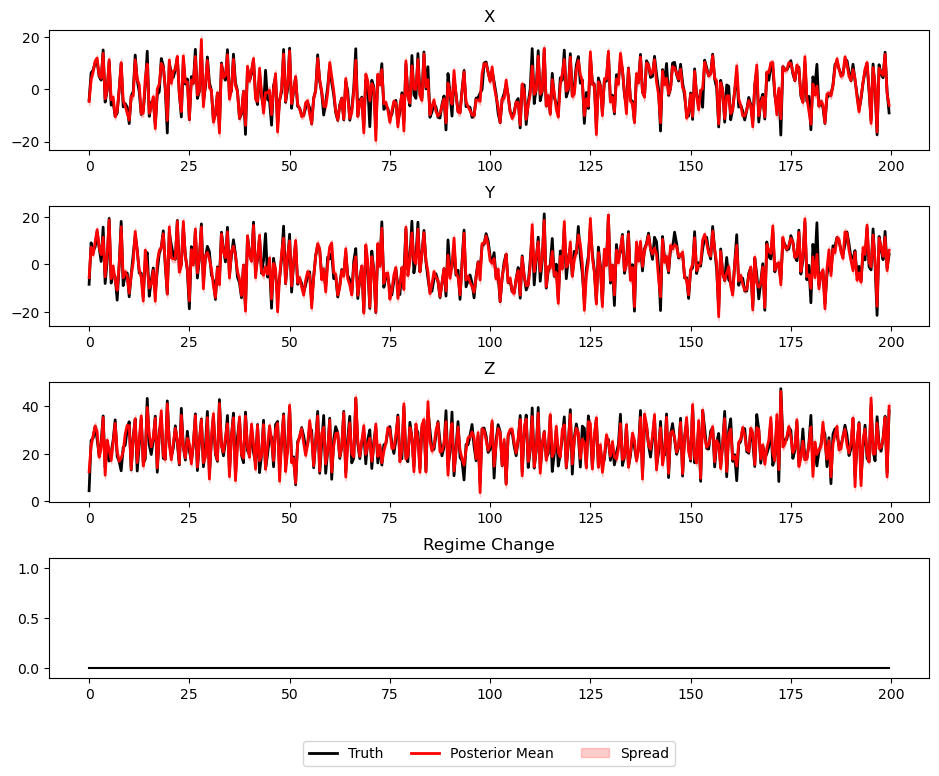

In [67]:
plot_l63_series(dt_obs, 0, 400, 1, truth[:,0], truth[:,1], truth[:,2], S_ens[0,:], analy_mean, analy_spread, S_ens[0,:], S_ens[0,:])

## 3.1. Mult-model EnKF with perfect regime models

In [27]:
import numpy as np
from enkf import eakf, construct_GC
from L63_noisy import L63RegimeModel
from sklearn.preprocessing import StandardScaler
from cluster import FCMEntropy
from scipy.linalg import expm
from scipy.optimize import minimize
from collections import deque
from time import time

def allocate_ensemble(ensemble_size, weights):
    '''input total ensemble size and model weights, return ensemble size for each model'''
    allocations = np.round(weights * ensemble_size).astype(int)
    excess = allocations.sum() - ensemble_size
    if excess > 0:
        max_idx = np.argmax(allocations)
        allocations[max_idx] -= excess
    elif excess < 0:
        min_idx = np.argmin(allocations)
        allocations[min_idx] -= excess  

    return allocations.tolist()

def reallocate_ens(initial_allocation, target_counts):
    '''reallocate ensemble members with minimal movements (pen for ensemble member, drawer for model)'''
    M = len(initial_allocation)
    initial_counts = [len(drawer) for drawer in initial_allocation]
    delta = [target_counts[i] - initial_counts[i] for i in range(M)]
    drawers = [list(pens) for pens in initial_allocation] # Create copy of allocation
    surplus = deque()
    deficit = deque()
    for i in range(M):
        if delta[i] < 0:
            surplus.append((i, -delta[i]))
        elif delta[i] > 0:
            deficit.append((i, delta[i]))
    while surplus and deficit:
        s_idx, s_amt = surplus[0]
        d_idx, d_amt = deficit[0]
        move_amt = min(s_amt, d_amt)
        for _ in range(move_amt):
            pen_id = drawers[s_idx].pop()
            drawers[d_idx].append(pen_id)
        # Update queue entries
        if s_amt > d_amt:
            surplus[0] = (s_idx, s_amt - move_amt)
            deficit.popleft()
        elif d_amt > s_amt:
            deficit[0] = (d_idx, d_amt - move_amt)
            surplus.popleft()
        else:
            surplus.popleft()
            deficit.popleft()

    return drawers

def markov_generator(mu0, muT, T):
    """
    Find a time-homogeneous generator matrix Q such that: muT ≈ mu0 @ expm(T * Q)
    Returns:
        Q_opt (np.ndarray): Optimal generator matrix (n x n)
        h (np.ndarray): Holding parameter (n,)
        R (np.ndarray): Routing matrix (n x n)
    """
    n = len(mu0)
    def objective(Q_flat):
        Q = Q_flat.reshape((n, n))
        P = expm(T * Q)
        mu_pred = mu0 @ P
        return np.sum((mu_pred - muT) ** 2)
    ineq_constr = {
        'type': 'ineq',
        'fun': lambda Q_flat: Q_flat.reshape((n, n))[~np.eye(n, dtype=bool)]
    }
    eq_constr = {
        'type': 'eq',
        'fun': lambda Q_flat: Q_flat.reshape((n, n)).sum(axis=1)
    }
    Q0 = np.random.rand(n, n)
    np.fill_diagonal(Q0, 0)
    Q0 = Q0 / Q0.sum(axis=1, keepdims=True)
    np.fill_diagonal(Q0, -Q0.sum(axis=1))
    Q0_flat = Q0.flatten()
    result = minimize(objective, Q0_flat, constraints=[ineq_constr, eq_constr], method='SLSQP')
    success = result.success
    if success:
        Q_opt = result.x.reshape((n, n))
        h = -np.diag(Q_opt)
        R = np.zeros_like(Q_opt)
        for i in range(len(Q_opt)):
            if h[i] > 0:
                R[i, :] = Q_opt[i, :] / h[i]
                R[i, i] = 0.0
        return Q_opt, h, R
    else:
        raise RuntimeError("Optimization failed: could not find a valid generator matrix.")
        
    
np.random.seed(0)

########################## load data ############################
data = np.load('../data/data_L63.npz')
N_gap = data['N_gap'].item()
truth_full = np.concatenate((data['x_truth'][:,None], data['y_truth'][:,None], data['z_truth'][:,None]), axis=1)[::N_gap]
obs_full = np.concatenate((data['x_obs'][:,None], data['y_obs'][:,None], data['z_obs'][:,None]), axis=1)
S_obs_full = data['S_obs'] # true regimes
train_size = 1600 # training data size
test_size = 400 # test data size

######################### clustering ############################
data = truth_full[:train_size]
S_obs = S_obs_full[:train_size]
Nt, D = data.shape
K = 2 # number of clusters (regimes)
L = 2 # time delay steps
data_embedded = np.concatenate([data[i:Nt - L + i + 1] for i in range(L)], axis=1) # (x0,y0,z0,x1,y1,z1,...)

# standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_embedded)

# fit the clustering model
cluster_model = FCMEntropy(num_clusters=K, D=D, m=1.6, lambda_e=1, num_steps=500, seed=3)
results = cluster_model.fit(data_scaled, optimizer='iterative', tol=1e-6)

# may need a function to automatically adjust the order of cluster centers to align with the prescibed regime order 

# save the clustering model
import pickle
fcm_model_data = {
    'centers': cluster_model.centers,
    'weights': cluster_model.weights,
    'config': {
        'num_clusters': cluster_model.num_clusters,
        'D': cluster_model.D,
        'm': cluster_model.m,
        'lambda_e': cluster_model.lambda_e,
    }}
with open('../data/fcm_model.pkl', 'wb') as f:
    pickle.dump(fcm_model_data, f)

# # load the clustering model
# with open('../data/fcm_model.pkl', 'rb') as f:
#     fcm_model_data = pickle.load(f)
# cluster_model = FCMEntropy(**fcm_model_data['config'])
# cluster_model.centers = fcm_model_data['centers']
# cluster_model.weights = fcm_model_data['weights']
"""
######################## multi-model DA ###########################
# truth = truth_full[:train_size]
# obs = obs_full[:train_size]
truth = truth_full[train_size:train_size+test_size]
obs = obs_full[train_size:train_size+test_size]
S_obs = S_obs_full[train_size:train_size+test_size]

# ---------------------- model parameters ---------------------
# Noise levels shared by all models
sigma_x = np.sqrt(2.0)
sigma_y = 1.0
sigma_z = 1.0
sigma_obs = 2 * np.sqrt(2)
# Models
models = [
    {'sigma': 10, 'beta': 8/3, 'rho': 28},
    {'sigma': 20, 'beta': 5,   'rho': 10},
    # {'sigma': 15, 'beta': 4,   'rho': 35}
]
# Regimes
regimes = [
    {'sigma': 10, 'beta': 8/3, 'rho': 28},
    {'sigma': 20, 'beta': 5,   'rho': 10},
]
n_models = len(models) # number of models
n_regimes = len(regimes) # number of regimes
dt = 5e-3 # Time step size
Nx = 3 # Number of grid points
mlocs = np.array([ix for ix in range(Nx)])
nmod = mlocs.shape[0] # number of model variables

# ------------------- observation parameters ------------------
obs_error_var = sigma_obs**2
dt_obs = 0.5
obs_freq_timestep = int(round(dt_obs / dt))
ylocs = mlocs
nobs = ylocs.shape[0]
nobstime = obs.shape[0]
R = np.eye(nobs) * obs_error_var
Hk = np.zeros((nobs, nmod))
for iobs in range(nobs):
    Hk[iobs, ylocs[iobs]] = 1.0

# ------------------------ DA parameters ------------------------
# analysis period
iobsbeg = 20
iobsend = -1

# eakf parameters
ensemble_size = 100
inflation_values = [1] # provide multiple values if for tuning
localization_values = [1] # provide multiple values if for tuning
ninf = len(inflation_values)
nloc = len(localization_values)
localize = 0 # localization: 1 for on / 0 for off
inflate = 0 # inflatin: 1 for on / 0 for off

# ---------------------- initialization -----------------------
ics = truth_full[:train_size]
n_ics = ics.shape[0]
weights = np.array([1/n_models] * n_models) # uniform initial weights
ensemble_sizes = allocate_ensemble(ensemble_size, weights)
ensemble_indices = [np.arange(start, start + size).tolist() for start, size in zip(np.cumsum([0] + ensemble_sizes[:-1]), ensemble_sizes)]
S0_ens = np.zeros(ensemble_size, dtype=int) # initial model
for m in range(n_models):
    S0_ens[ensemble_indices[m]] = m
ens0 = ics[np.random.randint(n_ics, size=ensemble_size)]
prior_rmse = np.zeros((nobstime,ninf,nloc))
analy_rmse = np.zeros((nobstime,ninf,nloc))
prior_err = np.zeros((ninf,nloc))
analy_err = np.zeros((ninf,nloc))

# ----------------------- assimilation -------------------------
for iinf in range(ninf):
    inflation_value = inflation_values[iinf]
    for iloc in range(nloc):
        localization_value = localization_values[iloc]

        prior_mean_model = np.zeros((nobstime, nmod, n_models))
        analy_mean_model = np.zeros((nobstime, nmod, n_models))
        prior_spread_model = np.zeros((nobstime, nmod, n_models))
        analy_spread_model = np.zeros((nobstime, nmod, n_models))
        prior_mean_mixture = np.zeros((nobstime, nmod))
        analy_mean_mixture = np.zeros((nobstime, nmod))
        prior_spread_mixture = np.zeros((nobstime, nmod))
        analy_spread_mixture = np.zeros((nobstime, nmod))
        prior_weights = np.zeros((nobstime, n_models))
        posterior_weights = np.zeros((nobstime, n_models))
        S_ens = np.zeros((nobstime, ensemble_size))
        ens = ens0

        t0 = time()
        for iassim in range(L-1, nobstime):
            prior_weights[iassim] = weights
            S_ens[iassim] = S0_ens
            for m in range(n_models):
                if ensemble_sizes[m] == 0:
                    weights[m] = 0 # posterior weight equals to zero
                elif ensemble_sizes[m] == 1:
                    # (no posterior updates for model weight and ensemble member)
                    ens_m = ens[ensemble_indices[m]]
                    prior_mean_model[iassim, :, m] = np.mean(ens_m, axis=0)
                    prior_spread_model[iassim, :, m] = prior_spread_model[iassim-1, :, m]
                    analy_mean_model[iassim, :, m] = np.mean(ens_m, axis=0)
                    analy_spread_model[iassim, :, m] = analy_spread_model[iassim-1, :, m]

                else:
                    ens_m = ens[ensemble_indices[m]]
                    prior_mean_m = np.mean(ens_m, axis=0)

                    # inflation RTPP
                    ens_m = prior_mean_m + (ens_m - prior_mean_m) * inflation_value if inflate == 1 else ens_m
                    # localization matrix        
                    CMat = construct_GC(localization_value, mlocs, ylocs)

                    # posterior model weights
                    obs_inc = obs[iassim] - Hk @ prior_mean_m
                    cov = Hk @ np.cov(ens_m.T) @ Hk.T + R
                    likelihhood = 1/(np.sqrt(np.linalg.det(cov))) * np.exp(-0.5 * obs_inc @ np.linalg.inv(cov) @ obs_inc)
                    weights[m] = weights[m] * likelihhood
                    
                    # EnKF serial update
                    prior_mean_model[iassim, :, m] = prior_mean_m
                    prior_spread_model[iassim, :, m] = np.std(ens_m, axis=0, ddof=1)
                    ens_m = eakf(ensemble_sizes[m], nobs, ens_m, Hk, obs_error_var, localize, CMat, obs[iassim])
                    ens[ensemble_indices[m]] = ens_m
                    analy_mean_model[iassim, :, m] = np.mean(ens_m, axis=0)
                    analy_spread_model[iassim, :, m] = np.std(ens_m, axis=0, ddof=1)

            # normalize to get posterior weights
            weights = weights / np.sum(weights)
            posterior_weights[iassim] = weights

            # Gaussian mixture mean and covariance
            prior_mean_mixture[iassim] = np.sum(prior_weights[iassim] * prior_mean_model[iassim], axis=1)
            prior_spread_mixture[iassim] = np.sqrt(np.sum(prior_weights[iassim] * (prior_spread_model[iassim]**2 + (prior_mean_model[iassim] - prior_mean_mixture[iassim][:,None])**2), axis=1))
            analy_mean_mixture[iassim] = np.sum(weights * analy_mean_model[iassim], axis=1)
            analy_spread_mixture[iassim] = np.sqrt(np.sum(weights * (analy_spread_model[iassim]**2 + (analy_mean_model[iassim] - analy_mean_mixture[iassim][:,None])**2), axis=1))

            # allocate ensemble members according to posterior weights
            ensemble_sizes = allocate_ensemble(ensemble_size, weights)
            ensemble_indices = reallocate_ens(ensemble_indices, ensemble_sizes) # greedy strategy with minimal movements
            for m in range(n_models):
                S0_ens[ensemble_indices[m]] = m

            # compute prior weights of the next assimilation step via clustering
            obs_embedded = np.concatenate([obs[iassim-L+i+1][None,:] for i in range(L)], axis=1) # (1,nobs*L); may use truth[iassim-L+1:iassim+1][None,:] in testing
            weights = cluster_model.predict(obs_embedded)[0,:]
            
            # multi-model ensemble forecast with continuous-time Markov process for model switching
            _, holding_parameters, routing_matrix = markov_generator(posterior_weights[iassim], weights, dt_obs)
            model = L63RegimeModel(models, routing_matrix, holding_parameters, sigma_x, sigma_y, sigma_z)
            if iassim < nobstime - 1:
                x1_ens, y1_ens, z1_ens, S1_ens = model.ensemble_forecast(obs_freq_timestep, dt, ens[:,0], ens[:,1], ens[:,2], S0_ens, ensemble_size)
                ens[:,0] = x1_ens[:, -1]
                ens[:,1] = y1_ens[:, -1]
                ens[:,2] = z1_ens[:, -1]
                S0_ens = S1_ens[:, -1]

        prior_rmse[:, iinf, iloc] = np.sqrt(np.mean((truth - prior_mean_mixture) ** 2, axis=1))
        analy_rmse[:, iinf, iloc] = np.sqrt(np.mean((truth - analy_mean_mixture) ** 2, axis=1))
        prior_err[iinf, iloc] = np.mean(prior_rmse[iobsbeg - 1: iobsend, iinf, iloc])
        analy_err[iinf, iloc] = np.mean(analy_rmse[iobsbeg - 1: iobsend, iinf, iloc])
        t1 = time()
        print('time used: {:.2f} hours'.format((t1-t0)/3600))

save = {
    'prior_mean_model': prior_mean_model,
    'analy_mean_model': analy_mean_model,
    'prior_spread_model': prior_spread_model,
    'analy_spread_model': analy_spread_model,
    'prior_mean_mixture': prior_mean_mixture,
    'analy_mean_mixture': analy_mean_mixture,
    'prior_spread_mixture': prior_spread_mixture,
    'analy_spread_mixture': analy_spread_mixture,
    'prior_weights': prior_weights,
    'posterior_weights': posterior_weights,
    'S_ens': S_ens,
    'prior_rmse': prior_rmse,
    'analy_rmse': analy_rmse,
}
np.savez('../data/MultimodelEnKF_L63.npz', **save)

prior_err = np.nan_to_num(prior_err, nan=999999)
analy_err = np.nan_to_num(analy_err, nan=999999)

# # uncomment these if for tuning inflation and localization
# minerr = np.min(prior_err)
# inds = np.where(prior_err == minerr)
# print('min prior mean rmse = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(minerr, inflation_values[inds[0][0]], localization_values[inds[1][0]]))
# minerr = np.min(analy_err)
# inds = np.where(analy_err == minerr)
# print('min analy mean rmse = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(minerr, inflation_values[inds[0][0]], localization_values[inds[1][0]]))

# uncomment these if for test
print('prior mean rmse = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(prior_err[0,0], inflation_values[0], localization_values[0]))
print('analy mean rmse = {0:.6e}, inflation = {1:.3e}, localizaiton = {2:d}'.format(analy_err[0,0], inflation_values[0], localization_values[0]))
"""

"\n######################## multi-model DA ###########################\n# truth = truth_full[:train_size]\n# obs = obs_full[:train_size]\ntruth = truth_full[train_size:train_size+test_size]\nobs = obs_full[train_size:train_size+test_size]\nS_obs = S_obs_full[train_size:train_size+test_size]\n\n# ---------------------- model parameters ---------------------\n# Noise levels shared by all models\nsigma_x = np.sqrt(2.0)\nsigma_y = 1.0\nsigma_z = 1.0\nsigma_obs = 2 * np.sqrt(2)\n# Models\nmodels = [\n    {'sigma': 10, 'beta': 8/3, 'rho': 28},\n    {'sigma': 20, 'beta': 5,   'rho': 10},\n    # {'sigma': 15, 'beta': 4,   'rho': 35}\n]\n# Regimes\nregimes = [\n    {'sigma': 10, 'beta': 8/3, 'rho': 28},\n    {'sigma': 20, 'beta': 5,   'rho': 10},\n]\nn_models = len(models) # number of models\nn_regimes = len(regimes) # number of regimes\ndt = 5e-3 # Time step size\nNx = 3 # Number of grid points\nmlocs = np.array([ix for ix in range(Nx)])\nnmod = mlocs.shape[0] # number of model variables\n\n# 

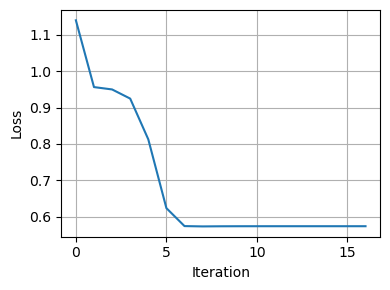

In [28]:
from plot import plot_loss
loss_history = results['loss_history']
plot_loss(loss_history)

In [29]:
data.shape

(1600, 3)

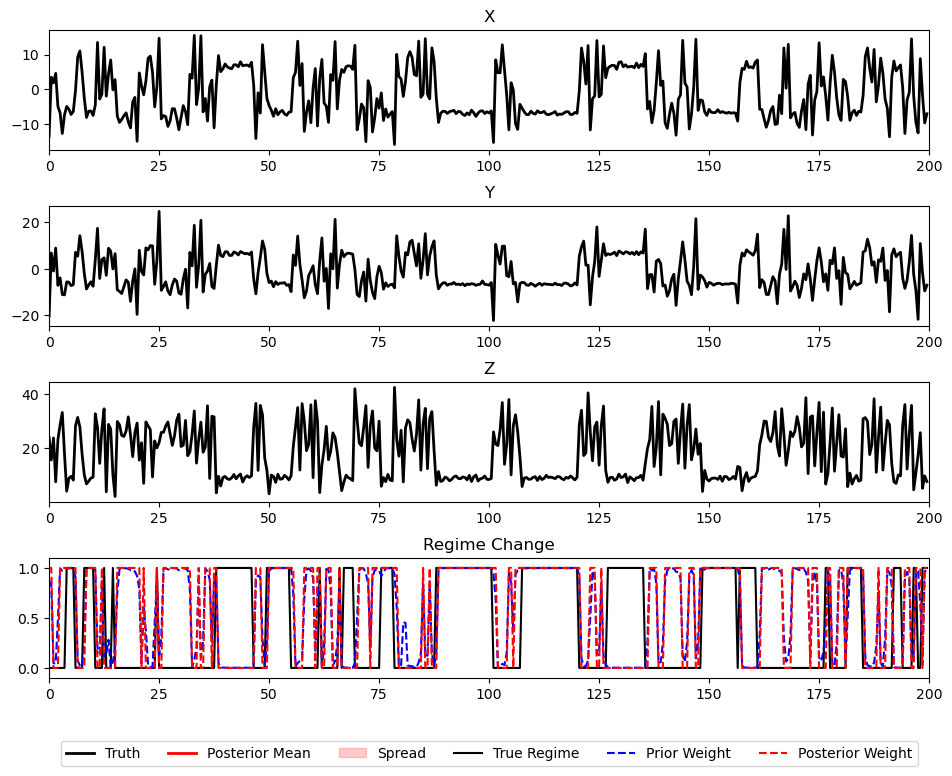

In [30]:
membership = results['membership']
centers = results['centers']
labels = np.argmax(membership, axis=1)
labels = -labels + 1
from plot import plot_l63_series
plot_l63_series(dt_obs, 0, 400, 1, data[1:,0], data[1:,1], data[1:,2], S_obs[1:], np.full((Nt-1,3), np.nan), np.zeros((Nt-1,3)), membership[:,0], labels, xlim=(0,200))

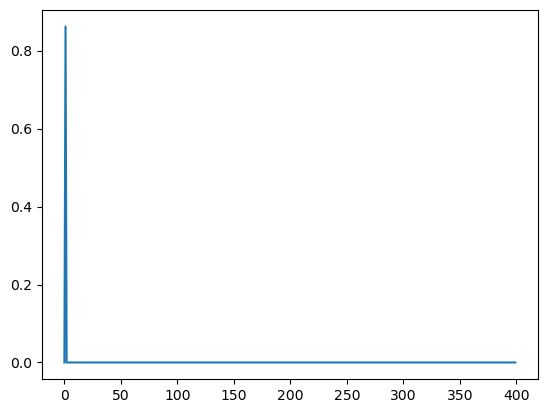

In [13]:
import matplotlib.pyplot as plt
plt.plot(posterior_weights[:,1])

In [3]:
S_obs = S_obs_full[train_size:train_size+test_size]


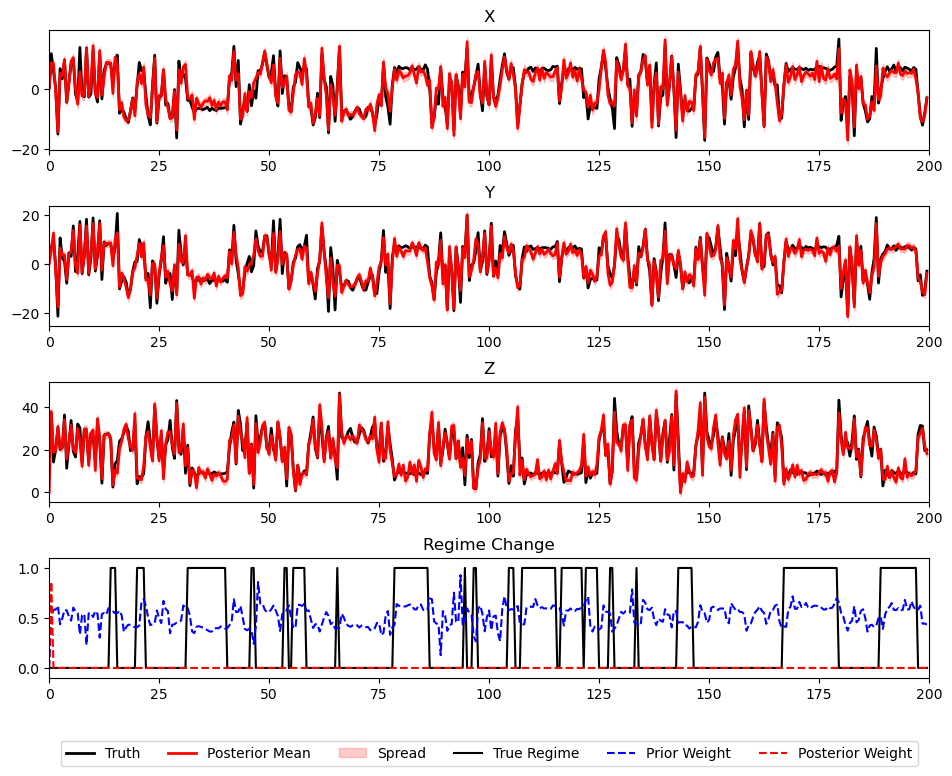

In [9]:
from plot import plot_l63_series
plot_l63_series(dt_obs, 0, 400, 1, truth[:,0], truth[:,1], truth[:,2], S_obs, analy_mean_mixture, analy_spread_mixture, prior_weights[:,1], posterior_weights[:,1], xlim=(0,200))

In [7]:
weights = [1/n_models] * n_models # uniform initial weights
ensemble_sizes = allocate_ensemble(ensemble_size, weights)
ensemble_indices = [np.arange(start, start + size).tolist() for start, size in zip(np.cumsum([0] + ensemble_sizes[:-1]), ensemble_sizes)]


In [5]:
data = np.arange(6).reshape(2,3)
np.concatenate([data[iassim-L+i+1][None,:] for i in range(L)], axis=1).shape

(1, 6)

In [10]:
data[[1],:].shape

(1, 3)

In [66]:
import numpy as np
from scipy.linalg import expm
from scipy.optimize import minimize

def find_generator_with_holding_routing(mu0, muT, T=1.0):
    """
    Find a time-homogeneous generator matrix Q such that: muT ≈ mu0 @ expm(T * Q)
    
    Returns:
        Q_opt (np.ndarray): Optimal generator matrix (n x n)
        h (np.ndarray): Holding parameter (n,)
        R (np.ndarray): Routing matrix (n x n)
    """
    n = len(mu0)
    def objective(Q_flat):
        Q = Q_flat.reshape((n, n))
        P = expm(T * Q)
        mu_pred = mu0 @ P
        return np.sum((mu_pred - muT) ** 2)
    ineq_constr = {
        'type': 'ineq',
        'fun': lambda Q_flat: Q_flat.reshape((n, n))[~np.eye(n, dtype=bool)]
    }
    eq_constr = {
        'type': 'eq',
        'fun': lambda Q_flat: Q_flat.reshape((n, n)).sum(axis=1)
    }

    Q0 = np.random.rand(n, n)
    np.fill_diagonal(Q0, 0)
    Q0 = Q0 / Q0.sum(axis=1, keepdims=True)
    np.fill_diagonal(Q0, -Q0.sum(axis=1))
    Q0_flat = Q0.flatten()
    result = minimize(objective, Q0_flat, constraints=[ineq_constr, eq_constr], method='SLSQP')
    success = result.success

    if success:
        Q_opt = result.x.reshape((n, n))
        muT_pred = mu0 @ expm(T * Q_opt)
        h = -np.diag(Q_opt)
        R = np.zeros_like(Q_opt)
        for i in range(len(Q_opt)):
            if h[i] > 0:
                R[i, :] = Q_opt[i, :] / h[i]
                R[i, i] = 0.0
        return Q_opt, h, R, muT_pred, success
    else:
        raise RuntimeError("Optimization failed: could not find a valid generator matrix.")
        
# === Example Usage ===
if __name__ == "__main__":
    mu0 = np.array([0.4, 0.3, 0.2, 0.1])
    muT = np.array([0.1, 0.2, 0.3, 0.4])
    T = 1.0

    Q, h, R, muT_pred, success = find_generator_with_holding_routing(mu0, muT, T)

    if success:
        print("\nHolding rates (h):", h)
        print("\nRouting matrix (R):\n", R)



Holding rates (h): [1.41433023 1.1847387  0.96825101 0.73089562]

Routing matrix (R):
 [[0.         0.05044898 0.40519156 0.54435946]
 [0.         0.         0.47329798 0.52670202]
 [0.02210559 0.21555611 0.         0.7623383 ]
 [0.         0.50007101 0.49992899 0.        ]]


In [12]:
import numpy as np

def allocate_ensemble(ensemble_size, weights):
    weights = np.array(weights, dtype=np.float64)
    weights = weights / weights.sum()  # normalize
    allocations = np.round(weights * ensemble_size).astype(int)
    excess = allocations.sum() - ensemble_size

    if excess > 0:
        # Reduce the largest allocation to fix the excess
        max_idx = np.argmax(allocations)
        allocations[max_idx] -= excess
    elif excess < 0:
        min_idx = np.argmin(allocations)
        allocations[min_idx] -= excess  # since excess is negative, this adds

    return allocations.tolist()


In [17]:
weights = np.array([1/n_models] * n_models) # uniform initial weights
ensemble_sizes = allocate_ensemble(ensemble_size, weights)
ensemble_sizes

[34, 33, 33]

In [15]:
def allocate_ensemble(ensemble_size, weights):
    '''input total ensemble size and model weights, return ensemble size for each model'''
    allocations = np.round(weights * ensemble_size).astype(int)
    excess = allocations.sum() - ensemble_size
    if excess > 0:
        max_idx = np.argmax(allocations)
        allocations[max_idx] -= excess
    elif excess < 0:
        min_idx = np.argmin(allocations)
        allocations[min_idx] -= excess  

    return allocations.tolist()

weights = np.array([1/3] * 3)
allocate_ensemble(10, weights)

[4, 3, 3]

In [19]:
ensemble_size = 10
weights = [0., 0.5, 0.5]
print(allocate_ensemble(ensemble_size, weights))
# Output: [2, 5, 3]


[0, 5, 5]


In [33]:
import numpy as np

# def get_ensemble_indices(ensemble_sizes):
#     ensemble_indices = []
#     current = 0
#     for size in ensemble_sizes:
#         indices = np.arange(current, current + size)
#         ensemble_indices.append(indices)
#         current += size
#     return ensemble_indices
def get_ensemble_indices(ensemble_sizes):
    return [np.arange(start, start + size) 
            for start, size in zip(np.cumsum([0] + ensemble_sizes[:-1]), ensemble_sizes)]

ensemble_sizes = [1, 6, 3]
ensemble_indices = get_ensemble_indices(ensemble_sizes)

for i, idx in enumerate(ensemble_indices):
    print(f"Model {i}: indices = {idx}")


Model 0: indices = [0]
Model 1: indices = [1 2 3 4 5 6]
Model 2: indices = [7 8 9]


In [71]:
ensemble_indices

[[0], [1, 2, 3, 4, 5, 6], [7, 8, 9]]

In [72]:
S0 = np.zeros(10, dtype=int)
for m in range(3):
    S0[ensemble_indices[m]] = m
S0


array([0., 1., 1., 1., 1., 1., 1., 2., 2., 2.])

In [42]:
ensemble_sizes = [1, 6, 3]
ensemble_indices = [np.arange(start, start + size).tolist() for start, size in zip(np.cumsum([0] + ensemble_sizes[:-1]), ensemble_sizes)]
ensemble_indices

[[0], [1, 2, 3, 4, 5, 6], [7, 8, 9]]

In [35]:
from collections import deque

def reallocate_ens(initial_allocation, target_counts):
    '''reallocate ensemble members with minimal movements (pen for ensemble member, drawer for model)'''
    M = len(initial_allocation)
    initial_counts = [len(drawer) for drawer in initial_allocation]
    delta = [target_counts[i] - initial_counts[i] for i in range(M)]
    drawers = [list(pens) for pens in initial_allocation] # Create copy of allocation
    surplus = deque()
    deficit = deque()
    for i in range(M):
        if delta[i] < 0:
            surplus.append((i, -delta[i]))
        elif delta[i] > 0:
            deficit.append((i, delta[i]))

    while surplus and deficit:
        s_idx, s_amt = surplus[0]
        d_idx, d_amt = deficit[0]
        move_amt = min(s_amt, d_amt)
        for _ in range(move_amt):
            pen_id = drawers[s_idx].pop()
            drawers[d_idx].append(pen_id)
        # Update queue entries
        if s_amt > d_amt:
            surplus[0] = (s_idx, s_amt - move_amt)
            deficit.popleft()
        elif d_amt > s_amt:
            deficit[0] = (d_idx, d_amt - move_amt)
            surplus.popleft()
        else:
            surplus.popleft()
            deficit.popleft()

    return drawers

initial_allocation = [
    [0],         # Drawer 0 has 2 pens
    [1, 2, 3],# Drawer 1 has 5 pens
    [4, 5, 6,7, 8, 9]       # Drawer 2 has 3 pens
]

target_counts = [6, 3, 1]  # Desired final drawer sizes

final_allocation = reallocate_pens(initial_allocation, target_counts)

for i, drawer in enumerate(final_allocation):
    print(f"Drawer {i}: {drawer}")


Drawer 0: [0, 9, 8, 7, 6, 5]
Drawer 1: [1, 2, 3]
Drawer 2: [4]


In [41]:
ensemble_indices[0].tolist()

[0]

In [43]:
final_allocation

[[0, 9, 8, 7, 6, 5], [1, 2, 3], [4]]

## 3.2 Multi-model DA with model errors

### 3.2.1 Model evaluation

Consider the forecast error $\mathcal{E}(A_t, X_0|S_0)$ conditioned on regime $S_0=k$, where $A_t$ is the target variable of interest at forecast lead time $t$, we aim for   
$$
\mathcal{E}(A_t, X_0|S_0) = \mathbb{E}_{X_0|S_0}[\mathcal{D}_{KL}(p(A_t|X_0)\| p^M(A_t|X_0))]
$$
(assuming a stochastic dynamical system). The marginalization over ${X_0|S_0}$ is intractable in practice. Instead, we seek for  
$$
\mathcal{E}(A_t,S_0) = \mathcal{D}_{KL}(p(A_t|S_0)\| p^M(A_t|S_0))
$$
where
$$
p(A_t|S_0) = \mathbb{E}_{X_0|S_0}[p(A_t|X_0)], \quad p^M(A_t|S_0) = \mathbb{E}_{X_0|S_0}[p^M(A_t|X_0)]
$$
By the convexity of the relative entropy,
$$
\mathbb{E}_{X_0|S_0}[\mathcal{D}_{KL}(p(A_t|X_0), p^M(A_t|X_0))] \geq \mathcal{D}_{KL}(\mathbb{E}_{X_0|S_0}[p(A_t|X_0)], \mathbb{E}_{X_0|S_0}[p^M(A_t|X_0)])
$$
that is
$$
\mathcal{E}(A_t, X_0|S_0) \geq \mathcal{E}(A_t,S_0)
$$
Therefore, by calculating $\mathcal{E}(A_t,S_0)$, we obtain an lower bound for $\mathcal{E}(A_t, X_0|S_0)$. It is easier to evaluate $\mathcal{E}(A_t,S_0)$ than $\mathcal{E}(A_t, X_0|S_0)$ in practice. Particularly, for the $k$-th regime, collect the values  
$$
\mathcal{A}^k_t=\{a_{t+t'}:S_{t'}=k\}
$$
from a sequence of data $x(t')$ and $a(t')$, where $S_{t'}=S(X_{t'})$ is the regime membership. Then calculate the histogram approximation 
$$
\hat{p}^k_t(i)=N_i/N,
$$
where $N_i$ is the number of elements in the bin $[a_{i-1},a_i]$, and $N=\sum_i N_i$. For an ergodic system, $\hat{p}^k_t(i)=N_i/N$ converges to $p^k_t:= p(A_t|S_0=k)$ as the number and bins and data samples go infinite.
 
(By using the approximation $\mathcal{E}(A_t,S_0)$, we compare the equilibrium distribution of regime $k$ instead of the expectation of forecast error at lead time $t$.)
  
The model performance score is defined as  
$$
\mathcal{C}(m;k) = \mathrm{exp}(-2\mathcal{E}_t^k) \in (0, 1]
$$
where $\mathcal{E}_t^k=\mathcal{E}(A_t,S_0=k)$.  

For the Lorenz 63 system in our case, there are two regimes $k=1,2$. The data $\mathbf{x}(t'):=(x_{t'}, y_{t'}, z_{t'}, x_{t'-1}, y_{t'-1}, z_{t'-1})$ includes a time window of all three variables $x$,$y$,$z$. The target variable $\mathbf{a}(t'):=(x_{t'}, y_{t'}, z_{t'})$. 

three models:


Since the initial data is assumed to be the same for perfect model and imperfect model, the imperfect forecast needs to be run seperately.

In [21]:
import numpy as np
from L63_noisy import L63RegimeModel
from model_evaluation import evaluate_model_error

np.random.seed(0)

data = np.load('../data/data_L63.npz')
dt = data['dt'].item()
N_gap = data['N_gap'].item()
dt_obs = data['dt_obs'].item()
N_gap = data['N_gap'].item()
truth_full = np.concatenate((data['x_truth'][:,None], data['y_truth'][:,None], data['z_truth'][:,None]), axis=1)
truth_full = truth_full[::N_gap]
S_obs = data['S_obs']
T = len(S_obs)
lead_time = 1
sigma_x = np.sqrt(2.0)
sigma_y = 1.0
sigma_z = 1.0
sigma_obs = 2 * np.sqrt(2)

models = [
    {'sigma': 10, 'beta': 8/3, 'rho': 28},
    {'sigma': 20, 'beta': 5,   'rho': 10},
    {'sigma': 15, 'beta': 4,   'rho': 35}
]
regimes = [
    {'sigma': 10, 'beta': 8/3, 'rho': 28},
    {'sigma': 20, 'beta': 5,   'rho': 10},
]
holding_parameters = np.array([0.2, 0.3, 0.4])

n_models = len(models)
n_regimes = len(regimes)
score_matrix = np.zeros((n_models, n_regimes))
for model_id in range(n_models):    
    routing_matrix = np.zeros((n_models, n_models))
    routing_matrix[:, model_id] = 1
    model = L63RegimeModel(models, routing_matrix, holding_parameters, sigma_x, sigma_y, sigma_z)

    for regime_id in range(n_regimes):
        idx = np.where(S_obs == regime_id)[0]
        idx = idx + lead_time
        idx = idx[idx < T]  # avoid index out of bounds
        X0 = truth_full[idx-lead_time]
        A_true = truth_full[idx]
        A_pred = np.zeros_like(A_true)
        T_pred = len(idx)
        
        for i in range(T_pred):
            x1, y1, z1, _ = model.forecast(N_gap, dt, X0[i,0], X0[i,1], X0[i,2], model_id)
            A_pred[i,0] = x1[-1]
            A_pred[i,1] = y1[-1]
            A_pred[i,2] = z1[-1]
            # kl_x1, p_x1, q_x1, bins_x1 = evaluate_model_error(A_data=A_true[:,0][:,None], A_model=A_pred[:,0][:,None], bins=30)
            # kl_y1, p_y1, q_y1, bins_y1 = evaluate_model_error(A_data=A_true[:,1][:,None], A_model=A_pred[:,1][:,None], bins=30)
            # kl_z1, p_z1, q_z1, bins_z1 = evaluate_model_error(A_data=A_true[:,2][:,None], A_model=A_pred[:,2][:,None], bins=30)
            kl_xyz_1, p_xyz_1, q_xyz_1, edges_xyz_1 = evaluate_model_error(A_data=A_true, A_model=A_pred, bins=10)
            model_score = np.exp(-2*kl_xyz_1)
            score_matrix[model_id, regime_id] = model_score
            # print(f"KL divergence for x in regime {regime_id:d}, model {model_id:d}: {kl_x1:.4f}")
            # print(f"KL divergence for y in regime {regime_id:d}, model {model_id:d}: {kl_y1:.4f}")
            # print(f"KL divergence for z in regime {regime_id:d}, model {model_id:d}: {kl_z1:.4f}")
            # print(f"KL divergence for (x,y,z) in regime {regime_id:d}, model {model_id:d}: {kl_xyz_1:.4f}")
            # print(f"model score in regime {regime_id:d}, model {model_id:d}: {model_score:.4e}")

weight_matrix = score_matrix / np.sum(score_matrix, axis=0)

np.savez('../data/model_evaluation.npz', 
         weight_matrix=weight_matrix,
         score_matrix=score_matrix,
         models=models,
         regimes=regimes
        )

In [22]:
score_matrix

array([[7.36354964e-02, 1.31181967e-21],
       [1.14660768e-19, 8.59722860e-03],
       [9.68034823e-03, 3.69545169e-22]])

In [23]:
weight_matrix

array([[8.83811437e-01, 1.52586343e-19],
       [1.37621804e-18, 1.00000000e+00],
       [1.16188563e-01, 4.29842204e-20]])

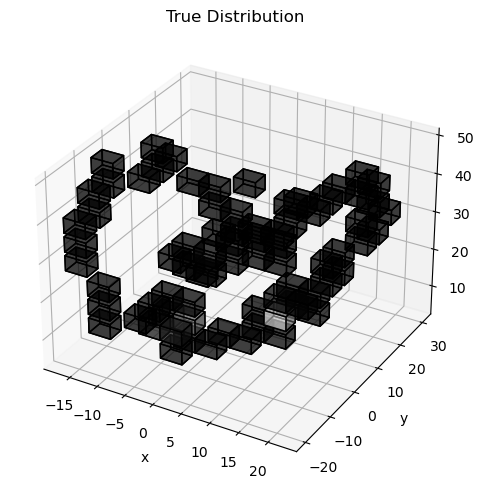

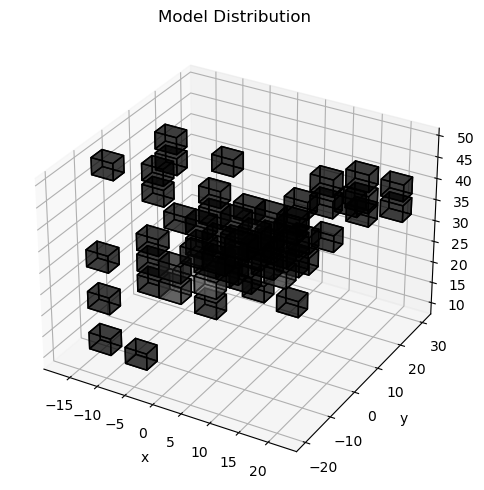

In [4]:
from plot import plot_3d_histogram
plot_3d_histogram(p_xyz_1, edges_xyz_1, title='True Distribution')
plot_3d_histogram(q_xyz_1, edges_xyz_1, title='Model Distribution')

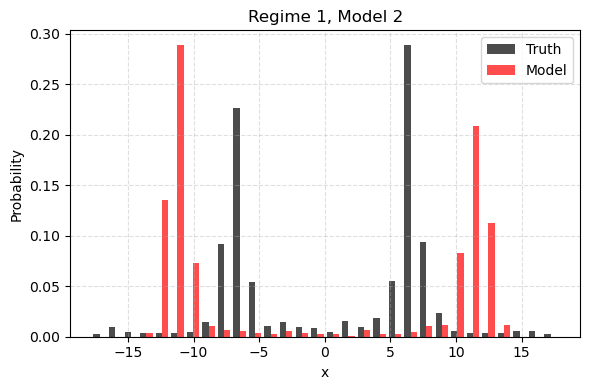

In [145]:
from plot import plot_histogram_comparison
plot_histogram_comparison(p_x1, q_x1, bins_x1, title=f'Regime {regime_id:d}, Model {model_id:d}', var_name='x')

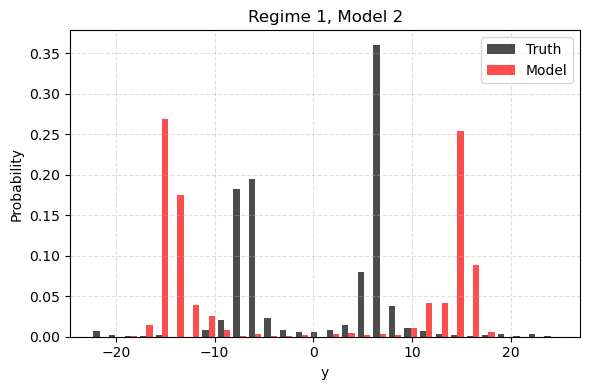

In [146]:
plot_histogram_comparison(p_y1, q_y1, bins_y1, title=f'Regime {regime_id:d}, Model {model_id:d}', var_name='y')

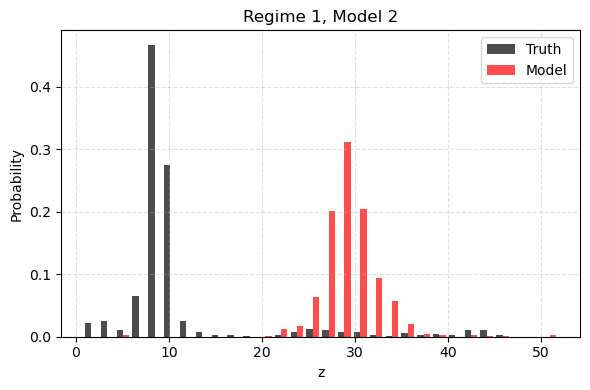

In [147]:
plot_histogram_comparison(p_z1, q_z1, bins_z1, title=f'Regime {regime_id:d}, Model {model_id:d}', var_name='z')